# **BENCHMARKING TRANSFER LEARNING STRATEGIES FOR TIME-SERIES IMAGING: RECOMMENDATIONS FOR ANALYZING VISUALIZED TIME SERIES DATA**

Main code for the IEEE article "Benchmarking Transfer Learning Strategies In Time-Series Imaging: Recommendations for Analyzing Raw Sensor Data"

In [2]:
# Tensorflow Version 2.x
%tensorflow_version 2.x

**Identify TF / Keras / Python Version**

In [3]:
import tensorflow
# Setup identification Tensorflow
print(tensorflow.__version__)

import keras
# Setup identification Keras
print(keras.__version__)

# Setup identification Python
!python3 --version

2.7.0
2.7.0
Python 3.7.12


# **Part 1 - Data Preparation:**

**Mount gdrive**

In [4]:
# Mount gdrive
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


**Import of Libraries for Data Preparation**

In [5]:
!pip install pyts

# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from pyts.image import GramianAngularField

     |████████████████████████████████| 2.5 MB 6.7 MB/s 


**Identification of Datasets**

In [7]:
datasets = [fileName for fileName in os.listdir('/data/CSVs') if fileName.endswith(".csv")]
datasets = np.sort([dataset.replace('.csv','') for dataset in datasets])
print(datasets)

['AbnormalHeartbeat' 'Computers' 'DodgerLoopGame' 'ECG200']


In [9]:
# Define dataset for investigation
ds = 3

data = pd.read_csv('/data/CSVs/' + datasets[ds] + '.csv')
data = data.dropna() # remove NA samples
data_notarget = data.drop(['target'], axis=1)
label = data['target'] # extract the labels

print('Dataset selected: ', datasets[ds])
print(data)

print('Number of observations with the label ', np.unique(label)[0], ' : ', sum(label == np.unique(label)[0]))
print('Number of observations with the label ', np.unique(label)[1], ' : ', sum(label == np.unique(label)[1]))

Dataset selected:  ECG200
         att1      att2      att3  ...     att95     att96  target
0    0.502055  0.542163  0.722383  ...  0.713815  0.433765      -1
1    0.147647  0.804668  0.367771  ... -1.265074 -0.208024       1
2    0.316646  0.243199  0.370471  ...  0.818042  0.539347      -1
3    1.168874  2.075901  1.760140  ...  0.800407  0.731540      -1
4    0.648658  0.752026  2.636231  ...  0.314590  0.582190       1
..        ...       ...       ...  ...       ...       ...     ...
195  0.843834  2.564764  3.343127  ... -0.023764  0.258732       1
196  1.398472  2.874771  3.453428  ... -0.451180 -0.100215       1
197  1.113685  1.275951  1.171770  ...  0.479638  0.358700      -1
198  2.318208  2.139772  1.794243  ...  0.285008  0.470914      -1
199  2.395329  3.283697  2.918598  ...  0.072660  0.215942       1

[200 rows x 97 columns]
Number of observations with the label  -1  :  67
Number of observations with the label  1  :  133


**Splitting Data**

In [10]:
# Split data into X (data) and label (y)
X = pd.DataFrame.to_numpy(data.iloc[:, 0:(len(data.columns)-1)])
y = pd.DataFrame.to_numpy(data['target']) 

timeseries = X[0]
timeseries = timeseries.reshape(1, -1)

**Exemplary GASF Image**

(-0.5, 63.5, -0.5, 63.5)

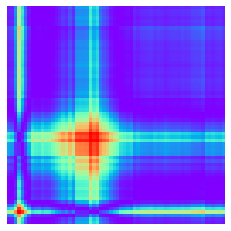

In [11]:
# Transform the time series into Gramian Angular Fields
gasf = GramianAngularField(image_size=64, method='summation')
X_gasf = gasf.fit_transform(timeseries)

# Show the images for the first time series
plt.imshow(X_gasf[0], cmap='rainbow', origin='lower')
plt.axis('off')

**Create and Export Time Series as GASF & GADF**

Dataset:  ECG200  ( GADF ) finished.


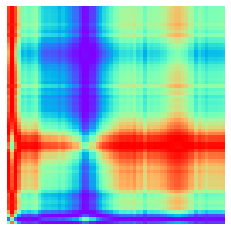

In [12]:
# Define the method
method = 'GADF'

if method == 'GASF':
  mthd = 'summation'
  mthd_path = '/GASF_Complete/'
elif method == 'GADF':
  mthd = 'difference'
  mthd_path = '/GADF_Complete/'

# Create directories if not existent
if not os.path.exists('/data/' + datasets[ds] + mthd_path + str(np.unique(label)[0]) + '/'):
  os.makedirs('/data/' + datasets[ds] + mthd_path + str(np.unique(label)[0]) + '/')

if not os.path.exists('/data/' + datasets[ds] + mthd_path + str(np.unique(label)[1]) + '/'):
  os.makedirs('/data/' + datasets[ds] + mthd_path + str(np.unique(label)[1]) + '/')

# Loop through all instances of the dataset, create and export visualized time series
for instance in range(0,len(y)):

  timeseries = X[instance]
  timeseries = timeseries.reshape(1, -1)

  if method=='GASF' or method=='GADF':
    # Transform the time series into Gramian Angular Fields
    gasf = GramianAngularField(image_size=64, method=mthd)
    X_gasf = gasf.fit_transform(timeseries)

    plt.imshow(X_gasf[0], cmap='rainbow', origin='lower')
    plt.axis('off')
  
  # Export the images
  if y[instance] == np.unique(label)[0]:
    img_path = '/data/' + datasets[ds] + mthd_path + str(np.unique(label)[0]) + '/image' + str(instance) + '.png'

  else:
    img_path = '/data/' + datasets[ds] + mthd_path + str(np.unique(label)[1]) + '/image' + str(instance) + '.png'

  plt.savefig(img_path, bbox_inches='tight', pad_inches=0)
  plt.close()

print('Dataset: ', datasets[ds], ' (', method, ') finished.')

# **Part 2 - Performance Evaluation:**

**Import of Libraries for Performance Evaluation**

In [17]:
# General
import pandas as pd
import numpy as np
import glob
import pickle
import os
import time
import warnings

# Scikit-Learn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, cohen_kappa_score, precision_score, recall_score, roc_auc_score

# Tensorflow
import tensorflow as tf
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16, VGG19, ResNet50V2, Xception

# Imbalanced-Learn
from imblearn.over_sampling import RandomOverSampler

**General (Network) Settings**

In [18]:
datasets = [fileName for fileName in os.listdir('/data/CSVs') if fileName.endswith(".csv")]
datasets = np.sort([dataset.replace('.csv','') for dataset in datasets])
print(datasets)

['AbnormalHeartbeat' 'Computers' 'DodgerLoopGame' 'ECG200']


In [19]:
# General settings
date = '311112'
ds = 3
method = 'GADF' # GASF / GADF

if method == 'GASF':
  mthd_path = '/GASF_Complete/'
elif method == 'GADF':
  mthd_path = '/GADF_Complete/'

# Define paths for data subset
sDataPath = '/data/' + datasets[ds] + mthd_path

# Image size
img_W = 64
img_H = 64

# Image channels to use: 3=RGB, (1=Grayscale)
channels = 3

# 20 rounds of training
nb_epoch = 20

# Batch size
bsize = 16

# Define batch size for directory flow according to dataset
if ds == 0:
  bsz = 606
elif ds == 1:
  bsz = 500
elif ds == 2:
  bsz = 144
elif ds == 3:
  bsz = 200

print('Dataset:', datasets[ds], 'and Visualization Method:', method, 'selected.')

label = []
label.append((glob.glob('/data/' + datasets[ds] + mthd_path + '*/'))[0].split('/')[9])
label.append((glob.glob('/data/' + datasets[ds] + mthd_path + '*/'))[1].split('/')[9])
label = np.sort(label)
print('Labels: ', label)

Dataset: ECG200 and Visualization Method: GADF selected.
Labels:  ['-1' '1']


##**Baseline Performance (Sequential CNN)**

**Define Basemodel (Sequential CNN)**

In [20]:
model = tf.keras.models.Sequential() # linear stack of layers providing a sequential netural network
model.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(img_W, img_H, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # reduce the size of the input
model.add(tf.keras.layers.Conv2D(64, (5, 5), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # reduce the size of the input
model.add(tf.keras.layers.Conv2D(64, (5, 5), activation='relu'))
model.add(tf.keras.layers.Flatten()) # flattens the input
model.add(tf.keras.layers.Dense(64, activation='relu')) # each node is connected to each node in the next layer
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # sigmoid activation function for binary classification task

# Compile CNN model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          102464    
                                                                 
 flatten (Flatten)           (None, 5184)              0

### Performance of Holdout 5-Fold Cross-Validation

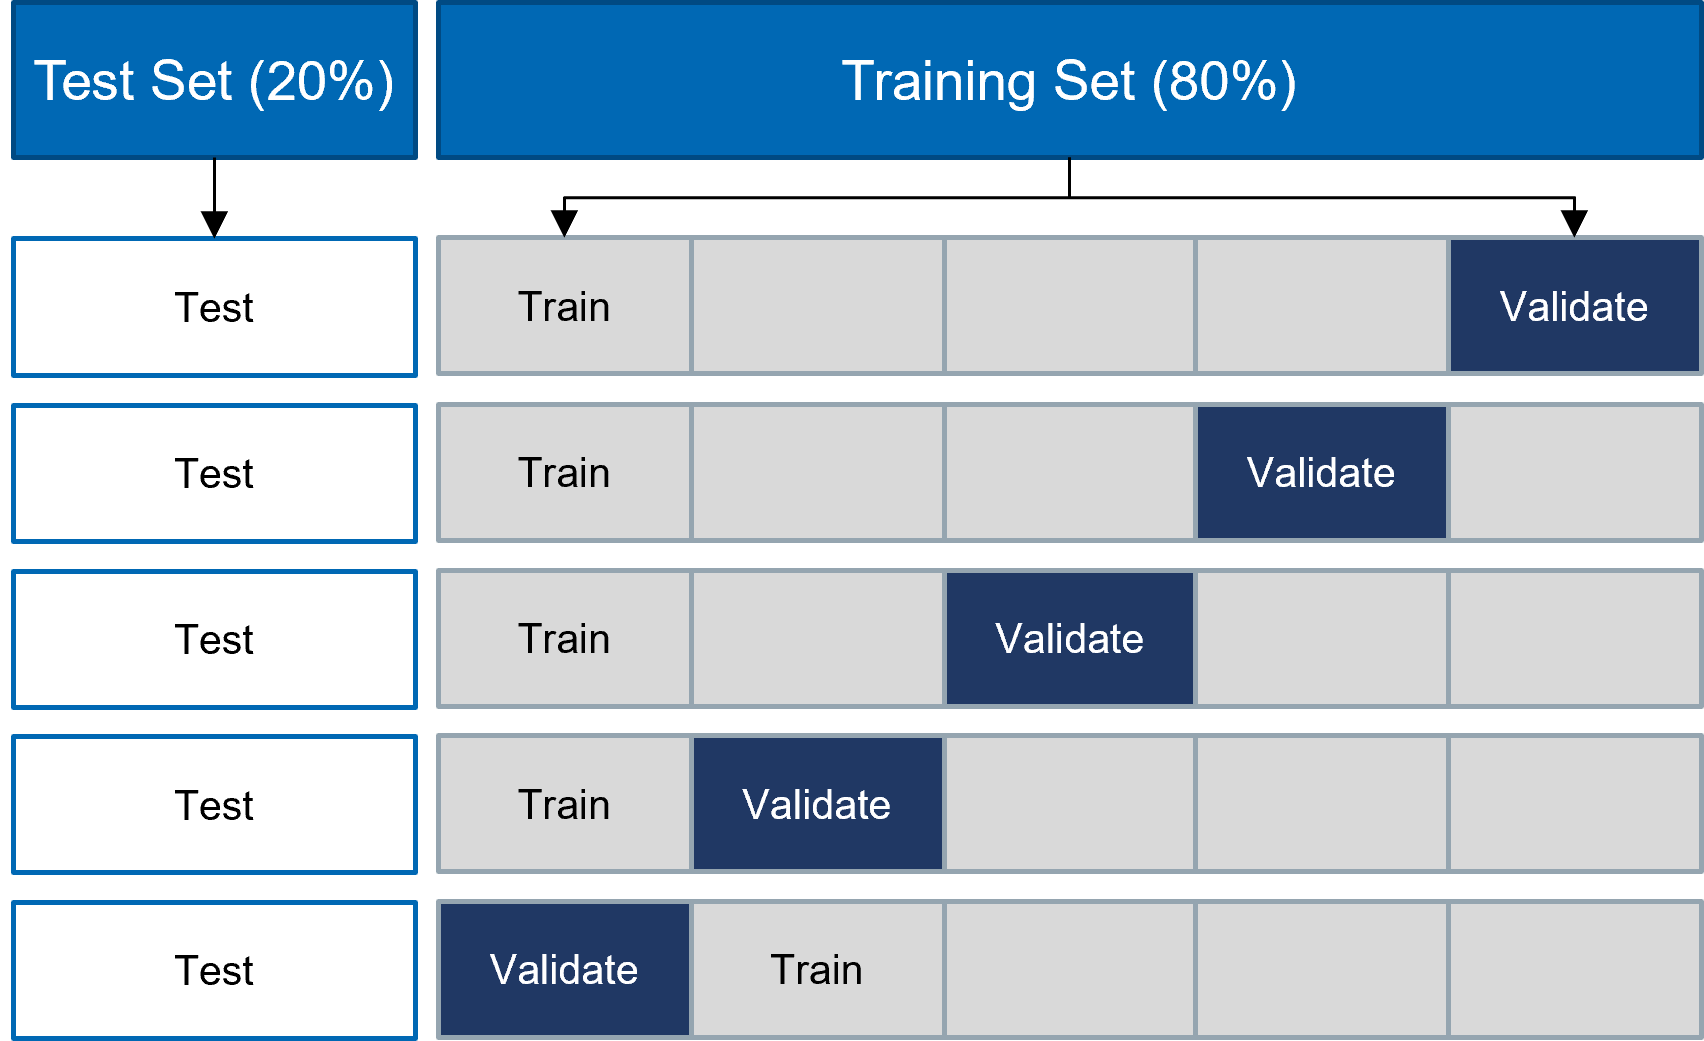

In [ ]:
# Load the data into RAM

# Automatically reads in all images and gets labels from direcetory names
data_generator = ImageDataGenerator()

# Read-in images and receive Labels
data_gen = data_generator.flow_from_directory(sDataPath,color_mode='rgb', 
                                                     class_mode='binary', target_size=(img_H, img_W), batch_size=bsz, shuffle=False)

# Read in all data at once and hold the complete set in RAM
warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)

for x_data_raw, y_data in data_gen:
    break

# Rescale data to [-1,1]
x_data = (x_data_raw * (1/127.5)) - 1

tp = 'Baseline' # define if basemodel or transfer learning strategy

# Number of folds
num_folds = 5

# Define variables for total scores
acc = []
balanced_acc = []
kappa = []
precision = []
recall = []
AUC = []
confusion_matrix = np.zeros((2, 2))

# Create hold-out-split (for final performance evaluation) with same class distribution as dataset (20%)
inputs, x_test, targets, y_test = train_test_split(x_data, y_data, stratify=y_data, test_size=0.2, random_state=42)

# Define 5-fold cross validator
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform 5 folds of cross-validation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  x_train = inputs[train]
  y_train = targets[train]
  x_validate = inputs[test]
  y_validate = targets[test]

  # If dataset manifests a class imbalanced - perform random oversampling (on the fly) on only the training data
  if (sum(label == np.unique(label)[0]) == sum(label == np.unique(label)[1])):  # Balanced classes. Data has not been oversampled.'
    x_over = x_train
    y_over = y_train
  else: # Oversample data
    oversample = RandomOverSampler(sampling_strategy='minority') # automatically balance the minority class with majority class
    # fit and apply the transform
    x_over, y_over = oversample.fit_resample(x_train, y_train)

  
  # Define checkpoints 
  checkpoint = ModelCheckpoint('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_Base_' + method + '_Fold' + str(fold_no) + '.h5', save_best_only=True)
  callb = [checkpoint]

  warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)
  
  # Base model training---------------------------------------------------------
  history = model.fit(x_over, y_over, batch_size=bsize, validation_data=(x_validate, y_validate),
          steps_per_epoch=len(x_train)//bsize, epochs=nb_epoch, callbacks=callb, verbose=1)
  
  # Save history for pretty plotting in future
  pickle.dump(history.history, open('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_Base_' + method + '_Fold' + str(fold_no) + '.pkl', 'wb'))
  time.sleep(5)
  
  # End of fold-----------------------------------------------------------------
  print('---------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  
  # Run predictions
  pred_probas = model.predict(x_test, verbose=1)
  predictions = (pred_probas > 0.5).astype('int32')
  predictions = np.concatenate(predictions)

  # Scores of current fold
  print(pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted']))
  print('Accuracy: %.5f' % accuracy_score(y_test, predictions))
  print('Balanced Acc: %.5f' % recall_score(y_test, predictions, average='macro'))
  print('Kappa: %.5f \n' % cohen_kappa_score(y_test, predictions))
  print('Precision: %.5f' % precision_score(y_test, predictions, average='weighted'))
  print('Recall: %.5f' % recall_score(y_test, predictions, average='weighted'))
  print('AUC: %.5f \n' % roc_auc_score(y_test, pred_probas))
  print('---------------------------------------------------------------------')
  
  # Appending results of fold to variables for total results
  acc.append(accuracy_score(y_test, predictions))
  balanced_acc.append(recall_score(y_test, predictions, average='macro'))
  kappa.append(cohen_kappa_score(y_test, predictions))
  precision.append(precision_score(y_test, predictions, average='weighted'))
  recall.append(recall_score(y_test, predictions, average='weighted'))
  AUC.append(roc_auc_score(y_test, pred_probas))
  confusion_matrix = confusion_matrix + pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])

  # Increase fold number
  fold_no = fold_no + 1

# Scores of all 5 folds
print('------------------------------------------------------------------------')
print('Score per fold')

for i in range(0, len(balanced_acc)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Balanced Acc: {balanced_acc[i]} - AUC: {AUC[i]}')
print('------------------------------------------------------------------------')

# Average scores over all 5 folds
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc)} (+- {np.std(acc)})')
print(f'> Balanced Accuracy: {np.mean(balanced_acc)} (+- {np.std(balanced_acc)})')
print(f'> Kappa: {np.mean(kappa)} (+- {np.std(kappa)})')
print(f'> Precision: {np.mean(precision)} (+- {np.std(precision)})')
print(f'> Recall: {np.mean(recall)} (+- {np.std(recall)})')
print(f'> AUC: {np.mean(AUC)} (+- {np.std(AUC)})')
print('\n> Confusion Matrix:')
print(f'> {data_gen.class_indices}')
print(confusion_matrix/(i+1))

##**Transfer Learning Performance (Pre-Trained Networks)**

### Performance of Holdout 5-Fold Cross-Validation (VGG16)

In [ ]:
# Load the data into RAM

# Automatically reads in all images and gets labels from direcetory names
data_generator = ImageDataGenerator()

# Read-in images and receive Labels
data_gen = data_generator.flow_from_directory(sDataPath,color_mode='rgb', 
                                                     class_mode='binary', target_size=(img_H, img_W), batch_size=bsz, shuffle=False)

# Read in all data at once and hold the complete set in RAM
warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)

for x_data_raw, y_data in data_gen:
    break

# Rescale data to [-1,1]
x_data = (x_data_raw * (1/127.5)) - 1

tp = 'TransferLearning' # define if basemodel or transfer learning strategy

# Number of folds
num_folds = 5

# Define variables for total scores
acc = []
balanced_acc = []
kappa = []
precision = []
recall = []
AUC = []
confusion_matrix = np.zeros((2, 2))

# Create hold-out-split (for final performance evaluation) with same class distribution as dataset (20%)
inputs, x_test, targets, y_test = train_test_split(x_data, y_data, stratify=y_data, test_size=0.2, random_state=42)

# Define 5-fold cross validator
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform 5 folds of cross-validation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  x_train = inputs[train]
  y_train = targets[train]
  x_validate = inputs[test]
  y_validate = targets[test]

  # If dataset manifests a class imbalanced - perform random oversampling (on the fly) on only the training data
  if (sum(label == np.unique(label)[0]) == sum(label == np.unique(label)[1])):  # Balanced classes. Data has not been oversampled.'
    x_over = x_train
    y_over = y_train
  else: # Oversample data
    oversample = RandomOverSampler(sampling_strategy='minority') # automatically balance the minority class with majority class
    # fit and apply the transform
    x_over, y_over = oversample.fit_resample(x_train, y_train)
  
  # Base model building---------------------------------------------------------
  base_model = VGG16(include_top=False, input_shape=(img_W, img_H, 3), pooling='avg')
  # Dense layers
  x = tf.keras.layers.Dense(128, name='Dense_1', activation='relu', kernel_regularizer=l2(), input_shape=base_model.output_shape[1:])(base_model.output)
  x = tf.keras.layers.Dropout(0.3, name='Dropout_1')(x)
  x = tf.keras.layers.Dense(64, name='Dense_2')(x)
  x = tf.keras.layers.Dropout(0.3)(x)
  # Define output-variable
  output = tf.keras.layers.Dense(1, name='output', activation='sigmoid')(x)
  # Define model
  model = tf.keras.models.Model(base_model.input, output)
  # Freeze Layers
  for layer in base_model.layers:
      layer.trainable = False
  model.compile(optimizer = tf.keras.optimizers.Adam(amsgrad=True), loss='binary_crossentropy', metrics=['accuracy'])
  
  # Define checkpoints 
  checkpoint = ModelCheckpoint('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_VGG16Base_' + method + '_Fold' + str(fold_no) + '.h5', save_best_only=True)
  callb = [checkpoint]
  
  warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)
  
  # Base model training---------------------------------------------------------
  history = model.fit(x_over, y_over, batch_size=bsize, validation_data=(x_validate, y_validate),
          steps_per_epoch=len(x_train)//bsize, epochs=nb_epoch, callbacks=callb, verbose=1)
  
  # Save history for pretty plotting in future
  pickle.dump(history.history, open('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_VGG16Base_' + method + '_Fold' + str(fold_no) + '.pkl', 'wb'))
  time.sleep(5)
  
  # Model fine tuning-----------------------------------------------------------
  model.load_weights('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_VGG16Base_' + method + '_Fold' + str(fold_no) + '.h5')
  for layer in model.layers[-18]:
    layer.trainable = True
  model.compile(optimizer = tf.keras.optimizers.Adam(1e-5, amsgrad=True), loss='binary_crossentropy', metrics=['accuracy'])

  # Fine tuned model------------------------------------------------------------
  history = model.fit(x_over, y_over, batch_size=bsize, validation_data=(x_validate, y_validate),
          steps_per_epoch=len(x_train)//bsize, epochs=nb_epoch, callbacks=callb, verbose=1)
  
  # Save history for pretty plotting in future
  pickle.dump(history.history, open('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_VGG16Tune_' + method + '_Fold' + str(fold_no) + '.pkl', 'wb'))
  # Load the best set of weights and save complete model
  model.save('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_VGG16Tune_' + method + '_Fold' + str(fold_no) + '.h5')
  
  # End of fold-----------------------------------------------------------------
  print('---------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  
  # Run predictions
  pred_probas = model.predict(x_test, verbose=1)
  predictions = (pred_probas > 0.5).astype('int32')
  predictions = np.concatenate(predictions)

  # Scores of current fold
  print(pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted']))
  print('Accuracy: %.5f' % accuracy_score(y_test, predictions))
  print('Balanced Acc: %.5f' % recall_score(y_test, predictions, average='macro'))
  print('Kappa: %.5f \n' % cohen_kappa_score(y_test, predictions))
  print('Precision: %.5f' % precision_score(y_test, predictions, average='weighted'))
  print('Recall: %.5f' % recall_score(y_test, predictions, average='weighted'))
  print('AUC: %.5f \n' % roc_auc_score(y_test, pred_probas))
  print('---------------------------------------------------------------------')
  
  # Appending results of fold to variables for total results
  acc.append(accuracy_score(y_test, predictions))
  balanced_acc.append(recall_score(y_test, predictions, average='macro'))
  kappa.append(cohen_kappa_score(y_test, predictions))
  precision.append(precision_score(y_test, predictions, average='weighted'))
  recall.append(recall_score(y_test, predictions, average='weighted'))
  AUC.append(roc_auc_score(y_test, pred_probas))
  confusion_matrix = confusion_matrix + pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])

  # Increase fold number
  fold_no = fold_no + 1

# Scores of all 5 folds
print('------------------------------------------------------------------------')
print('Score per fold')

for i in range(0, len(balanced_acc)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Balanced Acc: {balanced_acc[i]} - AUC: {AUC[i]}')
print('------------------------------------------------------------------------')

# Average scores over all 5 folds
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc)} (+- {np.std(acc)})')
print(f'> Balanced Accuracy: {np.mean(balanced_acc)} (+- {np.std(balanced_acc)})')
print(f'> Kappa: {np.mean(kappa)} (+- {np.std(kappa)})')
print(f'> Precision: {np.mean(precision)} (+- {np.std(precision)})')
print(f'> Recall: {np.mean(recall)} (+- {np.std(recall)})')
print(f'> AUC: {np.mean(AUC)} (+- {np.std(AUC)})')
print('\n> Confusion Matrix:')
print(f'> {data_gen.class_indices}')
print(confusion_matrix/(i+1))

### Performance of Holdout 5-Fold Cross-Validation (VGG19)

In [ ]:
# Load the data into RAM

# Automatically reads in all images and gets labels from direcetory names
data_generator = ImageDataGenerator()

# Read-in images and receive Labels
data_gen = data_generator.flow_from_directory(sDataPath,color_mode='rgb', 
                                                     class_mode='binary', target_size=(img_H, img_W), batch_size=bsz, shuffle=False)

# Read in all data at once and hold the complete set in RAM
warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)

for x_data_raw, y_data in data_gen:
    break

# Rescale data to [-1,1]
x_data = (x_data_raw * (1/127.5)) - 1

tp = 'TransferLearning' # define if basemodel or transfer learning strategy

# Number of folds
num_folds = 5

# Define variables for total scores
acc = []
balanced_acc = []
kappa = []
precision = []
recall = []
AUC = []
confusion_matrix = np.zeros((2, 2))

# Create hold-out-split (for final performance evaluation) with same class distribution as dataset (20%)
inputs, x_test, targets, y_test = train_test_split(x_data, y_data, stratify=y_data, test_size=0.2, random_state=42)

# Define 5-fold cross validator
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform 5 folds of cross-validation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  x_train = inputs[train]
  y_train = targets[train]
  x_validate = inputs[test]
  y_validate = targets[test]

  # If dataset manifests a class imbalanced - perform random oversampling (on the fly) on only the training data
  if (sum(label == np.unique(label)[0]) == sum(label == np.unique(label)[1])):  # Balanced classes. Data has not been oversampled.'
    x_over = x_train
    y_over = y_train
  else: # Oversample data
    oversample = RandomOverSampler(sampling_strategy='minority') # automatically balance the minority class with majority class
    # fit and apply the transform
    x_over, y_over = oversample.fit_resample(x_train, y_train)
  
  # Base model building---------------------------------------------------------
  base_model = VGG19(include_top=False, input_shape=(img_W, img_H, 3), pooling='avg')
  # Dense layers
  x = tf.keras.layers.Dense(128, name='Dense_1', activation='relu', kernel_regularizer=l2(), input_shape=base_model.output_shape[1:])(base_model.output)
  x = tf.keras.layers.Dropout(0.3, name='Dropout_1')(x)
  x = tf.keras.layers.Dense(64, name='Dense_2')(x)
  x = tf.keras.layers.Dropout(0.3)(x)
  # Define output-variable
  output = tf.keras.layers.Dense(1, name='output', activation='sigmoid')(x)
  # Define model
  model = tf.keras.models.Model(base_model.input, output)
  # Freeze Layers
  for layer in base_model.layers:
      layer.trainable = False
  model.compile(optimizer = tf.keras.optimizers.Adam(amsgrad=True), loss='binary_crossentropy', metrics=['accuracy'])
  
  # Define checkpoints 
  checkpoint = ModelCheckpoint('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_VGG19Base_' + method + '_Fold' + str(fold_no) + '.h5', save_best_only=True)
  callb = [checkpoint]
  
  warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)
  
  # Base model training---------------------------------------------------------
  history = model.fit(x_over, y_over, batch_size=bsize, validation_data=(x_validate, y_validate),
          steps_per_epoch=len(x_train)//bsize, epochs=nb_epoch, callbacks=callb, verbose=1)
  
  # Save history for pretty plotting in future
  pickle.dump(history.history, open('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_VGG19Base_' + method + '_Fold' + str(fold_no) + '.pkl', 'wb'))
  time.sleep(5)
  
  # Model fine tuning-----------------------------------------------------------
  model.load_weights('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_VGG19Base_' + method + '_Fold' + str(fold_no) + '.h5')
  for layer in model.layers[-18]:
    layer.trainable = True
  model.compile(optimizer = tf.keras.optimizers.Adam(1e-5, amsgrad=True), loss='binary_crossentropy', metrics=['accuracy'])

  # Fine tuned model------------------------------------------------------------
  history = model.fit(x_over, y_over, batch_size=bsize, validation_data=(x_validate, y_validate),
          steps_per_epoch=len(x_train)//bsize, epochs=nb_epoch, callbacks=callb, verbose=1)
  
  # Save history for pretty plotting in future
  pickle.dump(history.history, open('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_VGG19Tune_' + method + '_Fold' + str(fold_no) + '.pkl', 'wb'))
  # Load the best set of weights and save complete model
  model.save('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_VGG19Tune_' + method + '_Fold' + str(fold_no) + '.h5')
  
  # End of fold-----------------------------------------------------------------
  print('---------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  
  # Run predictions
  pred_probas = model.predict(x_test, verbose=1)
  predictions = (pred_probas > 0.5).astype('int32')
  predictions = np.concatenate(predictions)

  # Scores of current fold
  print(pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted']))
  print('Accuracy: %.5f' % accuracy_score(y_test, predictions))
  print('Balanced Acc: %.5f' % recall_score(y_test, predictions, average='macro'))
  print('Kappa: %.5f \n' % cohen_kappa_score(y_test, predictions))
  print('Precision: %.5f' % precision_score(y_test, predictions, average='weighted'))
  print('Recall: %.5f' % recall_score(y_test, predictions, average='weighted'))
  print('AUC: %.5f \n' % roc_auc_score(y_test, pred_probas))
  print('---------------------------------------------------------------------')
  
  # Appending results of fold to variables for total results
  acc.append(accuracy_score(y_test, predictions))
  balanced_acc.append(recall_score(y_test, predictions, average='macro'))
  kappa.append(cohen_kappa_score(y_test, predictions))
  precision.append(precision_score(y_test, predictions, average='weighted'))
  recall.append(recall_score(y_test, predictions, average='weighted'))
  AUC.append(roc_auc_score(y_test, pred_probas))
  confusion_matrix = confusion_matrix + pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])

  # Increase fold number
  fold_no = fold_no + 1

# Scores of all 5 folds
print('------------------------------------------------------------------------')
print('Score per fold')

for i in range(0, len(balanced_acc)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Balanced Acc: {balanced_acc[i]} - AUC: {AUC[i]}')
print('------------------------------------------------------------------------')

# Average scores over all 5 folds
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc)} (+- {np.std(acc)})')
print(f'> Balanced Accuracy: {np.mean(balanced_acc)} (+- {np.std(balanced_acc)})')
print(f'> Kappa: {np.mean(kappa)} (+- {np.std(kappa)})')
print(f'> Precision: {np.mean(precision)} (+- {np.std(precision)})')
print(f'> Recall: {np.mean(recall)} (+- {np.std(recall)})')
print(f'> AUC: {np.mean(AUC)} (+- {np.std(AUC)})')
print('\n> Confusion Matrix:')
print(f'> {data_gen.class_indices}')
print(confusion_matrix/(i+1))

### Performance of Holdout 5-Fold Cross-Validation (ResNet50V2)

In [ ]:
# Load the data into RAM

# Automatically reads in all images and gets labels from direcetory names
data_generator = ImageDataGenerator()

# Read-in images and receive Labels
data_gen = data_generator.flow_from_directory(sDataPath,color_mode='rgb', 
                                                     class_mode='binary', target_size=(img_H, img_W), batch_size=bsz, shuffle=False)

# Read in all data at once and hold the complete set in RAM
warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)

for x_data_raw, y_data in data_gen:
    break

# Rescale data to [-1,1]
x_data = (x_data_raw * (1/127.5)) - 1

tp = 'TransferLearning' # define if basemodel or transfer learning strategy

# Number of folds
num_folds = 5

# Define variables for total scores
acc = []
balanced_acc = []
kappa = []
precision = []
recall = []
AUC = []
confusion_matrix = np.zeros((2, 2))

# Create hold-out-split (for final performance evaluation) with same class distribution as dataset (20%)
inputs, x_test, targets, y_test = train_test_split(x_data, y_data, stratify=y_data, test_size=0.2, random_state=42)

# Define 5-fold cross validator
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform 5 folds of cross-validation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  x_train = inputs[train]
  y_train = targets[train]
  x_validate = inputs[test]
  y_validate = targets[test]

  # If dataset manifests a class imbalanced - perform random oversampling (on the fly) on only the training data
  if (sum(label == np.unique(label)[0]) == sum(label == np.unique(label)[1])):  # Balanced classes. Data has not been oversampled.'
    x_over = x_train
    y_over = y_train
  else: # Oversample data
    oversample = RandomOverSampler(sampling_strategy='minority') # automatically balance the minority class with majority class
    # fit and apply the transform
    x_over, y_over = oversample.fit_resample(x_train, y_train)
  
  # Base model building---------------------------------------------------------
  base_model = ResNet50V2(include_top=False, input_shape=(img_W, img_H, 3), pooling='avg')
  # Dense layers
  x = tf.keras.layers.Dense(128, name='Dense_1', activation='relu', kernel_regularizer=l2(), input_shape=base_model.output_shape[1:])(base_model.output)
  x = tf.keras.layers.Dropout(0.3, name='Dropout_1')(x)
  x = tf.keras.layers.Dense(64, name='Dense_2')(x)
  x = tf.keras.layers.Dropout(0.3)(x)
  # Define output-variable
  output = tf.keras.layers.Dense(1, name='output', activation='sigmoid')(x)
  # Define model
  model = tf.keras.models.Model(base_model.input, output)
  # Freeze Layers
  for layer in base_model.layers:
      layer.trainable = False
  model.compile(optimizer = tf.keras.optimizers.Adam(amsgrad=True), loss='binary_crossentropy', metrics=['accuracy'])
  
  # Define checkpoints 
  checkpoint = ModelCheckpoint('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_ResNetBase_' + method + '_Fold' + str(fold_no) + '.h5', save_best_only=True)
  callb = [checkpoint]
  
  warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)
  
  # Base model training---------------------------------------------------------
  history = model.fit(x_over, y_over, batch_size=bsize, validation_data=(x_validate, y_validate),
          steps_per_epoch=len(x_train)//bsize, epochs=nb_epoch, callbacks=callb, verbose=1)
  
  # Save history for pretty plotting in future
  pickle.dump(history.history, open('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_ResNetBase_' + method + '_Fold' + str(fold_no) + '.pkl', 'wb'))
  time.sleep(5)
  
  # Model fine tuning-----------------------------------------------------------
  model.load_weights('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_ResNetBase_' + method + '_Fold' + str(fold_no) + '.h5')
  for layer in model.layers[-16]:
    layer.trainable = True
  model.compile(optimizer = tf.keras.optimizers.Adam(1e-5, amsgrad=True), loss='binary_crossentropy', metrics=['accuracy'])

  # Fine tuned model------------------------------------------------------------
  history = model.fit(x_over, y_over, batch_size=bsize, validation_data=(x_validate, y_validate),
          steps_per_epoch=len(x_train)//bsize, epochs=nb_epoch, callbacks=callb, verbose=1)
  
  # Save history for pretty plotting in future
  pickle.dump(history.history, open('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_ResNetTune_' + method + '_Fold' + str(fold_no) + '.pkl', 'wb'))
  # Load the best set of weights and save complete model
  model.save('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_ResNetTune_' + method + '_Fold' + str(fold_no) + '.h5')
  
  # End of fold-----------------------------------------------------------------
  print('---------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  
  # Run predictions
  pred_probas = model.predict(x_test, verbose=1)
  predictions = (pred_probas > 0.5).astype('int32')
  predictions = np.concatenate(predictions)

  # Scores of current fold
  print(pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted']))
  print('Accuracy: %.5f' % accuracy_score(y_test, predictions))
  print('Balanced Acc: %.5f' % recall_score(y_test, predictions, average='macro'))
  print('Kappa: %.5f \n' % cohen_kappa_score(y_test, predictions))
  print('Precision: %.5f' % precision_score(y_test, predictions, average='weighted'))
  print('Recall: %.5f' % recall_score(y_test, predictions, average='weighted'))
  print('AUC: %.5f \n' % roc_auc_score(y_test, pred_probas))
  print('---------------------------------------------------------------------')
  
  # Appending results of fold to variables for total results
  acc.append(accuracy_score(y_test, predictions))
  balanced_acc.append(recall_score(y_test, predictions, average='macro'))
  kappa.append(cohen_kappa_score(y_test, predictions))
  precision.append(precision_score(y_test, predictions, average='weighted'))
  recall.append(recall_score(y_test, predictions, average='weighted'))
  AUC.append(roc_auc_score(y_test, pred_probas))
  confusion_matrix = confusion_matrix + pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])

  # Increase fold number
  fold_no = fold_no + 1

# Scores of all 5 folds
print('------------------------------------------------------------------------')
print('Score per fold')

for i in range(0, len(balanced_acc)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Balanced Acc: {balanced_acc[i]} - AUC: {AUC[i]}')
print('------------------------------------------------------------------------')

# Average scores over all 5 folds
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc)} (+- {np.std(acc)})')
print(f'> Balanced Accuracy: {np.mean(balanced_acc)} (+- {np.std(balanced_acc)})')
print(f'> Kappa: {np.mean(kappa)} (+- {np.std(kappa)})')
print(f'> Precision: {np.mean(precision)} (+- {np.std(precision)})')
print(f'> Recall: {np.mean(recall)} (+- {np.std(recall)})')
print(f'> AUC: {np.mean(AUC)} (+- {np.std(AUC)})')
print('\n> Confusion Matrix:')
print(f'> {data_gen.class_indices}')
print(confusion_matrix/(i+1))

### Performance of Holdout 5-Fold Cross-Validation (Xception)

In [ ]:
# For Xception: if include_top=False, width and height should be no smaller than 71
img_W = 71
img_H = 71

# Load the data into RAM

# Automatically reads in all images and gets labels from direcetory names
data_generator = ImageDataGenerator()

# Read-in images and receive Labels
data_gen = data_generator.flow_from_directory(sDataPath,color_mode='rgb', 
                                                     class_mode='binary', target_size=(img_H, img_W), batch_size=bsz, shuffle=False) 

# Read in all data at once and hold the complete set in RAM
warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)

for x_data_raw, y_data in data_gen:
    break

# Rescale data to [-1,1]
x_data = (x_data_raw * (1/127.5)) - 1

tp = 'TransferLearning' # define if basemodel or transfer learning strategy

# Number of folds
num_folds = 5

# Define variables for total scores
acc = []
balanced_acc = []
kappa = []
precision = []
recall = []
AUC = []
confusion_matrix = np.zeros((2, 2))

# Create hold-out-split (for final performance evaluation) with same class distribution as dataset (20%)
inputs, x_test, targets, y_test = train_test_split(x_data, y_data, stratify=y_data, test_size=0.2, random_state=42)

# Define 5-fold cross validator
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform 5 folds of cross-validation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  x_train = inputs[train]
  y_train = targets[train]
  x_validate = inputs[test]
  y_validate = targets[test]

  # If dataset manifests a class imbalanced - perform random oversampling (on the fly) on only the training data
  if (sum(label == np.unique(label)[0]) == sum(label == np.unique(label)[1])):  # Balanced classes. Data has not been oversampled.'
    x_over = x_train
    y_over = y_train
  else: # Oversample data
    oversample = RandomOverSampler(sampling_strategy='minority') # automatically balance the minority class with majority class
    # fit and apply the transform
    x_over, y_over = oversample.fit_resample(x_train, y_train)
  
  # Base model building---------------------------------------------------------
  base_model = Xception(include_top=False, input_shape=(img_W, img_H, 3), pooling='avg')
  # Dense layers
  x = tf.keras.layers.Dense(128, name='Dense_1', activation='relu', kernel_regularizer=l2(), input_shape=base_model.output_shape[1:])(base_model.output)
  x = tf.keras.layers.Dropout(0.3, name='Dropout_1')(x)
  x = tf.keras.layers.Dense(64, name='Dense_2')(x)
  x = tf.keras.layers.Dropout(0.3)(x)
  # Define output-variable
  output = tf.keras.layers.Dense(1, name='output', activation='sigmoid')(x)
  # Define model
  model = tf.keras.models.Model(base_model.input, output)
  # Freeze Layers
  for layer in base_model.layers:
      layer.trainable = False
  model.compile(optimizer = tf.keras.optimizers.Adam(amsgrad=True), loss='binary_crossentropy', metrics=['accuracy'])
  
  # Define checkpoints 
  checkpoint = ModelCheckpoint('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_XcepBase_' + method + '_Fold' + str(fold_no) + '.h5', save_best_only=True)
  callb = [checkpoint]
  
  warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)
  
  # Base model training---------------------------------------------------------
  history = model.fit(x_over, y_over, batch_size=bsize, validation_data=(x_validate, y_validate),
          steps_per_epoch=len(x_train)//bsize, epochs=nb_epoch, callbacks=callb, verbose=1)
  
  # Save history for pretty plotting in future
  pickle.dump(history.history, open('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_XcepBase_' + method + '_Fold' + str(fold_no) + '.pkl', 'wb'))
  time.sleep(5)
  
  # Model fine tuning-----------------------------------------------------------
  model.load_weights('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_XcepBase_' + method + '_Fold' + str(fold_no) + '.h5')
  for layer in model.layers[-10]:
    layer.trainable = True
  model.compile(optimizer = tf.keras.optimizers.Adam(1e-5, amsgrad=True), loss='binary_crossentropy', metrics=['accuracy'])

  # Fine tuned model------------------------------------------------------------
  history = model.fit(x_over, y_over, batch_size=bsize, validation_data=(x_validate, y_validate),
          steps_per_epoch=len(x_train)//bsize, epochs=nb_epoch, callbacks=callb, verbose=1)
  
  # Save history for pretty plotting in future
  pickle.dump(history.history, open('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_XcepTune_' + method + '_Fold' + str(fold_no) + '.pkl', 'wb'))
  # Load the best set of weights and save complete model
  model.save('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_XcepTune_' + method + '_Fold' + str(fold_no) + '.h5')
  
  # End of fold-----------------------------------------------------------------
  print('---------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  
  # Run predictions
  pred_probas = model.predict(x_test, verbose=1)
  predictions = (pred_probas > 0.5).astype('int32')
  predictions = np.concatenate(predictions)

  # Scores of current fold
  print(pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted']))
  print('Accuracy: %.5f' % accuracy_score(y_test, predictions))
  print('Balanced Acc: %.5f' % recall_score(y_test, predictions, average='macro'))
  print('Kappa: %.5f \n' % cohen_kappa_score(y_test, predictions))
  print('Precision: %.5f' % precision_score(y_test, predictions, average='weighted'))
  print('Recall: %.5f' % recall_score(y_test, predictions, average='weighted'))
  print('AUC: %.5f \n' % roc_auc_score(y_test, pred_probas))
  print('---------------------------------------------------------------------')
  
  # Appending results of fold to variables for total results
  acc.append(accuracy_score(y_test, predictions))
  balanced_acc.append(recall_score(y_test, predictions, average='macro'))
  kappa.append(cohen_kappa_score(y_test, predictions))
  precision.append(precision_score(y_test, predictions, average='weighted'))
  recall.append(recall_score(y_test, predictions, average='weighted'))
  AUC.append(roc_auc_score(y_test, pred_probas))
  confusion_matrix = confusion_matrix + pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])

  # Increase fold number
  fold_no = fold_no + 1

# Scores of all 5 folds
print('------------------------------------------------------------------------')
print('Score per fold')

for i in range(0, len(balanced_acc)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Balanced Acc: {balanced_acc[i]} - AUC: {AUC[i]}')
print('------------------------------------------------------------------------')

# Average scores over all 5 folds
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc)} (+- {np.std(acc)})')
print(f'> Balanced Accuracy: {np.mean(balanced_acc)} (+- {np.std(balanced_acc)})')
print(f'> Kappa: {np.mean(kappa)} (+- {np.std(kappa)})')
print(f'> Precision: {np.mean(precision)} (+- {np.std(precision)})')
print(f'> Recall: {np.mean(recall)} (+- {np.std(recall)})')
print(f'> AUC: {np.mean(AUC)} (+- {np.std(AUC)})')
print('\n> Confusion Matrix:')
print(f'> {data_gen.class_indices}')
print(confusion_matrix/(i+1))

##**VGG16 Performance (Feature Level Variants)**

### Performance of Holdout 5-Fold Cross-Validation (VGG16-MLF)

In [ ]:
# Load the data into RAM

# Automatically reads in all images and gets labels from direcetory names
data_generator = ImageDataGenerator()

# Read-in images and receive Labels
data_gen = data_generator.flow_from_directory(sDataPath,color_mode='rgb', 
                                                     class_mode='binary', target_size=(img_H, img_W), batch_size=bsz, shuffle=False)

# Read in all data at once and hold the complete set in RAM
warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)

for x_data_raw, y_data in data_gen:
    break

# Rescale data to [-1,1]
x_data = (x_data_raw * (1/127.5)) - 1

tp = 'TransferLearning' # define if basemodel or transfer learning strategy

# Number of folds
num_folds = 5

# Define variables for total scores
acc = []
balanced_acc = []
kappa = []
precision = []
recall = []
AUC = []
confusion_matrix = np.zeros((2, 2))

# Create hold-out-split (for final performance evaluation) with same class distribution as dataset (20%)
inputs, x_test, targets, y_test = train_test_split(x_data, y_data, stratify=y_data, test_size=0.2, random_state=42)

# Define 5-fold cross validator
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform 5 folds of cross-validation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  x_train = inputs[train]
  y_train = targets[train]
  x_validate = inputs[test]
  y_validate = targets[test]

  # If dataset manifests a class imbalanced - perform random oversampling (on the fly) on only the training data
  if (sum(label == np.unique(label)[0]) == sum(label == np.unique(label)[1])):  # Balanced classes. Data has not been oversampled.'
    x_over = x_train
    y_over = y_train
  else: # Oversample data
    oversample = RandomOverSampler(sampling_strategy='minority') # automatically balance the minority class with majority class
    # fit and apply the transform
    x_over, y_over = oversample.fit_resample(x_train, y_train)
  
  # Base model building---------------------------------------------------------
  base_model = VGG16(include_top=False, input_shape=(img_W, img_H, 3), pooling='avg')
  # Dense layers
  x = tf.keras.layers.Dense(128, name='Dense_1', activation='relu', kernel_regularizer=l2(), input_shape=base_model.output_shape[1:])(base_model.output)
  x = tf.keras.layers.Dropout(0.3, name='Dropout_1')(x)
  x = tf.keras.layers.Dense(64, name='Dense_2')(x)
  x = tf.keras.layers.Dropout(0.3)(x)
  # Define output-variable
  output = tf.keras.layers.Dense(1, name='output', activation='sigmoid')(x)
  # Define model
  model = tf.keras.models.Model(base_model.input, output)
  # Freeze Layers
  for layer in base_model.layers:
      layer.trainable = False
  model.compile(optimizer = tf.keras.optimizers.Adam(amsgrad=True), loss='binary_crossentropy', metrics=['accuracy'])
  
  # Define checkpoints 
  checkpoint = ModelCheckpoint('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_VGG16MLFBase_' + method + '_Fold' + str(fold_no) + '.h5', save_best_only=True)
  callb = [checkpoint]
  
  warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)
  
  # Base model training---------------------------------------------------------
  history = model.fit(x_over, y_over, batch_size=bsize, validation_data=(x_validate, y_validate),
          steps_per_epoch=len(x_train)//bsize, epochs=nb_epoch, callbacks=callb, verbose=1)
  
  # Save history for pretty plotting in future
  pickle.dump(history.history, open('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_VGG16MLFBase_' + method + '_Fold' + str(fold_no) + '.pkl', 'wb'))
  time.sleep(5)
  
  # Model fine tuning-----------------------------------------------------------
  model.load_weights('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_VGG16MLFBase_' + method + '_Fold' + str(fold_no) + '.h5')
  for layer in model.layers[-14]:
    layer.trainable = True
  model.compile(optimizer = tf.keras.optimizers.Adam(1e-5, amsgrad=True), loss='binary_crossentropy', metrics=['accuracy'])

  # Fine tuned model------------------------------------------------------------
  history = model.fit(x_over, y_over, batch_size=bsize, validation_data=(x_validate, y_validate),
          steps_per_epoch=len(x_train)//bsize, epochs=nb_epoch, callbacks=callb, verbose=1)
  
  # Save history for pretty plotting in future
  pickle.dump(history.history, open('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_VGG16MLFTune_' + method + '_Fold' + str(fold_no) + '.pkl', 'wb'))
  # Load the best set of weights and save complete model
  model.save('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_VGG16MLFTune_' + method + '_Fold' + str(fold_no) + '.h5')
  
  # End of fold-----------------------------------------------------------------
  print('---------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  
  # Run predictions
  pred_probas = model.predict(x_test, verbose=1)
  predictions = (pred_probas > 0.5).astype('int32')
  predictions = np.concatenate(predictions)

  # Scores of current fold
  print(pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted']))
  print('Accuracy: %.5f' % accuracy_score(y_test, predictions))
  print('Balanced Acc: %.5f' % recall_score(y_test, predictions, average='macro'))
  print('Kappa: %.5f \n' % cohen_kappa_score(y_test, predictions))
  print('Precision: %.5f' % precision_score(y_test, predictions, average='weighted'))
  print('Recall: %.5f' % recall_score(y_test, predictions, average='weighted'))
  print('AUC: %.5f \n' % roc_auc_score(y_test, pred_probas))
  print('---------------------------------------------------------------------')
  
  # Appending results of fold to variables for total results
  acc.append(accuracy_score(y_test, predictions))
  balanced_acc.append(recall_score(y_test, predictions, average='macro'))
  kappa.append(cohen_kappa_score(y_test, predictions))
  precision.append(precision_score(y_test, predictions, average='weighted'))
  recall.append(recall_score(y_test, predictions, average='weighted'))
  AUC.append(roc_auc_score(y_test, pred_probas))
  confusion_matrix = confusion_matrix + pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])

  # Increase fold number
  fold_no = fold_no + 1

# Scores of all 5 folds
print('------------------------------------------------------------------------')
print('Score per fold')

for i in range(0, len(balanced_acc)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Balanced Acc: {balanced_acc[i]} - AUC: {AUC[i]}')
print('------------------------------------------------------------------------')

# Average scores over all 5 folds
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc)} (+- {np.std(acc)})')
print(f'> Balanced Accuracy: {np.mean(balanced_acc)} (+- {np.std(balanced_acc)})')
print(f'> Kappa: {np.mean(kappa)} (+- {np.std(kappa)})')
print(f'> Precision: {np.mean(precision)} (+- {np.std(precision)})')
print(f'> Recall: {np.mean(recall)} (+- {np.std(recall)})')
print(f'> AUC: {np.mean(AUC)} (+- {np.std(AUC)})')
print('\n> Confusion Matrix:')
print(f'> {data_gen.class_indices}')
print(confusion_matrix/(i+1))

### Performance of Holdout 5-Fold Cross-Validation (VGG16-HLF)

In [ ]:
# Load the data into RAM

# Automatically reads in all images and gets labels from direcetory names
data_generator = ImageDataGenerator()

# Read-in images and receive Labels
data_gen = data_generator.flow_from_directory(sDataPath,color_mode='rgb', 
                                                     class_mode='binary', target_size=(img_H, img_W), batch_size=bsz, shuffle=False)

# Read in all data at once and hold the complete set in RAM
warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)

for x_data_raw, y_data in data_gen:
    break

# Rescale data to [-1,1]
x_data = (x_data_raw * (1/127.5)) - 1

tp = 'TransferLearning' # define if basemodel or transfer learning strategy

# Number of folds
num_folds = 5

# Define variables for total scores
acc = []
balanced_acc = []
kappa = []
precision = []
recall = []
AUC = []
confusion_matrix = np.zeros((2, 2))

# Create hold-out-split (for final performance evaluation) with same class distribution as dataset (20%)
inputs, x_test, targets, y_test = train_test_split(x_data, y_data, stratify=y_data, test_size=0.2, random_state=42)

# Define 5-fold cross validator
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform 5 folds of cross-validation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  x_train = inputs[train]
  y_train = targets[train]
  x_validate = inputs[test]
  y_validate = targets[test]

  # If dataset manifests a class imbalanced - perform random oversampling (on the fly) on only the training data
  if (sum(label == np.unique(label)[0]) == sum(label == np.unique(label)[1])):  # Balanced classes. Data has not been oversampled.'
    x_over = x_train
    y_over = y_train
  else: # Oversample data
    oversample = RandomOverSampler(sampling_strategy='minority') # automatically balance the minority class with majority class
    # fit and apply the transform
    x_over, y_over = oversample.fit_resample(x_train, y_train)
  
  # Base model building---------------------------------------------------------
  base_model = VGG16(include_top=False, input_shape=(img_W, img_H, 3), pooling='avg')
  # Dense layers
  x = tf.keras.layers.Dense(128, name='Dense_1', activation='relu', kernel_regularizer=l2(), input_shape=base_model.output_shape[1:])(base_model.output)
  x = tf.keras.layers.Dropout(0.3, name='Dropout_1')(x)
  x = tf.keras.layers.Dense(64, name='Dense_2')(x)
  x = tf.keras.layers.Dropout(0.3)(x)
  # Define output-variable
  output = tf.keras.layers.Dense(1, name='output', activation='sigmoid')(x)
  # Define model
  model = tf.keras.models.Model(base_model.input, output)
  # Freeze Layers
  for layer in base_model.layers:
      layer.trainable = False
  model.compile(optimizer = tf.keras.optimizers.Adam(amsgrad=True), loss='binary_crossentropy', metrics=['accuracy'])
  
  # Define checkpoints 
  checkpoint = ModelCheckpoint('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_VGG16HLFBase_' + method + '_Fold' + str(fold_no) + '.h5', save_best_only=True)
  callb = [checkpoint]
  
  warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)
  
  # Base model training---------------------------------------------------------
  history = model.fit(x_over, y_over, batch_size=bsize, validation_data=(x_validate, y_validate),
          steps_per_epoch=len(x_train)//bsize, epochs=nb_epoch, callbacks=callb, verbose=1)
  
  # Save history for pretty plotting in future
  pickle.dump(history.history, open('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_VGG16HLFBase_' + method + '_Fold' + str(fold_no) + '.pkl', 'wb'))
  time.sleep(5)
  
  # Model fine tuning-----------------------------------------------------------
  model.load_weights('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_VGG16HLFBase_' + method + '_Fold' + str(fold_no) + '.h5')
  for layer in model.layers[-10]:
    layer.trainable = True
  model.compile(optimizer = tf.keras.optimizers.Adam(1e-5, amsgrad=True), loss='binary_crossentropy', metrics=['accuracy'])

  # Fine tuned model------------------------------------------------------------
  history = model.fit(x_over, y_over, batch_size=bsize, validation_data=(x_validate, y_validate),
          steps_per_epoch=len(x_train)//bsize, epochs=nb_epoch, callbacks=callb, verbose=1)
  
  # Save history for pretty plotting in future
  pickle.dump(history.history, open('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_VGG16HLFTune_' + method + '_Fold' + str(fold_no) + '.pkl', 'wb'))
  # Load the best set of weights and save complete model
  model.save('/data/' + datasets[ds] + '/Models_History/' + tp + '/' + date + '_' + datasets[ds] + '_VGG16HLFTune_' + method + '_Fold' + str(fold_no) + '.h5')
  
  # End of fold-----------------------------------------------------------------
  print('---------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  
  # Run predictions
  pred_probas = model.predict(x_test, verbose=1)
  predictions = (pred_probas > 0.5).astype('int32')
  predictions = np.concatenate(predictions)

  # Scores of current fold
  print(pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted']))
  print('Accuracy: %.5f' % accuracy_score(y_test, predictions))
  print('Balanced Acc: %.5f' % recall_score(y_test, predictions, average='macro'))
  print('Kappa: %.5f \n' % cohen_kappa_score(y_test, predictions))
  print('Precision: %.5f' % precision_score(y_test, predictions, average='weighted'))
  print('Recall: %.5f' % recall_score(y_test, predictions, average='weighted'))
  print('AUC: %.5f \n' % roc_auc_score(y_test, pred_probas))
  print('---------------------------------------------------------------------')
  
  # Appending results of fold to variables for total results
  acc.append(accuracy_score(y_test, predictions))
  balanced_acc.append(recall_score(y_test, predictions, average='macro'))
  kappa.append(cohen_kappa_score(y_test, predictions))
  precision.append(precision_score(y_test, predictions, average='weighted'))
  recall.append(recall_score(y_test, predictions, average='weighted'))
  AUC.append(roc_auc_score(y_test, pred_probas))
  confusion_matrix = confusion_matrix + pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])

  # Increase fold number
  fold_no = fold_no + 1

# Scores of all 5 folds
print('------------------------------------------------------------------------')
print('Score per fold')

for i in range(0, len(balanced_acc)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Balanced Acc: {balanced_acc[i]} - AUC: {AUC[i]}')
print('------------------------------------------------------------------------')

# Average scores over all 5 folds
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc)} (+- {np.std(acc)})')
print(f'> Balanced Accuracy: {np.mean(balanced_acc)} (+- {np.std(balanced_acc)})')
print(f'> Kappa: {np.mean(kappa)} (+- {np.std(kappa)})')
print(f'> Precision: {np.mean(precision)} (+- {np.std(precision)})')
print(f'> Recall: {np.mean(recall)} (+- {np.std(recall)})')
print(f'> AUC: {np.mean(AUC)} (+- {np.std(AUC)})')
print('\n> Confusion Matrix:')
print(f'> {data_gen.class_indices}')
print(confusion_matrix/(i+1))

# **Part 3 - Figure Creation:**

**Import of Libraries for Figure Creation**

In [ ]:
!pip install pyts

# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import cv2
import os
import glob
from pyts.image import GramianAngularField
tf.compat.v1.disable_eager_execution()

# Scikit-Learn
from sklearn.model_selection import train_test_split

# Tensorflow
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Matplotlib
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib.offsetbox import AnchoredText
from matplotlib.lines import Line2D

**General Settings**

In [52]:
datasets = [fileName for fileName in os.listdir('/data/CSVs') if fileName.endswith(".csv")]
datasets = np.sort([dataset.replace('.csv','') for dataset in datasets])
print(datasets)

['AbnormalHeartbeat' 'Computers' 'DodgerLoopGame' 'ECG200']


**Data Preparation for Plotting**

In [27]:
# Load each dataset individually and extract labels

# AbnormalHeartbeat
data = pd.read_csv('/data/CSVs/' + datasets[0] + '.csv')
data = data.dropna()
data_notarget = data.drop(['target'], axis=1)
label = data['target']

# Computers
data2 = pd.read_csv('/data/CSVs/' + datasets[1] + '.csv')
data2 = data2.dropna()
data2_notarget = data2.drop(['target'], axis=1)
label2 = data2['target']

# DodgerLoopGame
data3 = pd.read_csv('/data/CSVs/' + datasets[2] + '.csv')
data3 = data3.dropna()
data3_notarget = data3.drop(['target'], axis=1)
label3 = data3['target']

# ECG200
data4 = pd.read_csv('/data/CSVs/' + datasets[3] + '.csv')
data4 = data4.dropna()
data4_notarget = data4.drop(['target'], axis=1)
label4 = data4['target']

# Identify indices for positive and negative class per dataset

# AbnormalHeartbeat
indices_label0 = np.where(data[['target']]==np.unique(label)[0])[0]
indices_label1 = np.where(data[['target']]==np.unique(label)[1])[0]

# Computers
indices2_label0 = np.where(data2[['target']]==np.unique(label2)[0])[0]
indices2_label1 = np.where(data2[['target']]==np.unique(label2)[1])[0]

# DodgerLoopGame
indices3_label0 = np.where(data3[['target']]==np.unique(label3)[0])[0]
indices3_label1 = np.where(data3[['target']]==np.unique(label3)[1])[0]

# ECG200
indices4_label0 = np.where(data4[['target']]==np.unique(label4)[0])[0]
indices4_label1 = np.where(data4[['target']]==np.unique(label4)[1])[0]

##**Example Visualizations Datasets**

In [ ]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16)) = plt.subplots(4, 4, figsize=(13.25,14))

# Define x and y data for each dataset

# Abnormal Heartbeat
x = range(0, len(np.asarray(data_notarget.loc[indices_label1[0],:])))
y_c0 = np.asarray(data_notarget.loc[indices_label0[0],:])
y_c1 = np.asarray(data_notarget.loc[indices_label1[0],:])

# Computers
x2 = range(0, len(np.asarray(data2_notarget.loc[indices2_label1[0],:])))
y2_c0 = np.asarray(data2_notarget.loc[indices2_label0[0],:])
y2_c1 = np.asarray(data2_notarget.loc[indices2_label1[0],:])

# DodgerLoopGame
x3 = range(0, len(np.asarray(data3_notarget.loc[indices3_label1[0],:])))
y3_c0 = np.asarray(data3_notarget.loc[indices3_label0[0],:])
y3_c1 = np.asarray(data3_notarget.loc[indices3_label1[0],:])

# ECG200
x4 = range(0, len(np.asarray(data4_notarget.loc[indices4_label1[0],:])))
y4_c0 = np.asarray(data4_notarget.loc[indices4_label0[0],:])
y4_c1 = np.asarray(data4_notarget.loc[indices4_label1[0],:])

# General plot parameters
fm.fontManager.addfont('/graphics/times.ttf')
fm._rebuild()
plt.rcParams['axes.titlesize'] = 26
plt.rcParams['font.family'] = 'Times New Roman'

# Plot each subplot
ax1.plot(x, y_c0, color='dodgerblue')  
ax1.grid(True)
ax1.set_xticks(np.arange(min(x), max(x)+1, 500))
ax5.imshow(GramianAngularField(method='summation').fit_transform(y_c0.reshape(1, -1))[0], cmap='rainbow', origin='lower', aspect="auto")
ax5.grid(True)
ax5.set_xticks(np.arange(min(x), max(x)+1, 500))
ax5.set_yticks(np.arange(min(x), max(x)+1, 500))

ax2.plot(x, y_c1, color='orangered')
ax2.grid(True)
ax2.set_xticks(np.arange(min(x), max(x)+1, 500))
ax6.imshow(GramianAngularField(method='summation').fit_transform(y_c1.reshape(1, -1))[0], cmap='rainbow', origin='lower', aspect="auto")
ax6.grid(True)
ax6.set_xticks(np.arange(min(x), max(x)+1, 500))
ax6.set_yticks(np.arange(min(x), max(x)+1, 500))


ax3.plot(x2, y2_c0, color='dodgerblue')
ax3.grid(True)
ax3.set_xticks(np.arange(min(x2), max(x2)+1, 100))
ax7.imshow(GramianAngularField(method='summation').fit_transform(y2_c0.reshape(1, -1))[0], cmap='rainbow', origin='lower', aspect="auto")
ax7.grid(True)
ax7.set_xticks(np.arange(min(x2), max(x2)+1, 100))
ax7.set_yticks(np.arange(min(x2), max(x2)+1, 100))

ax4.plot(x2, y2_c1, color='orangered')
ax4.grid(True)
ax4.set_xticks(np.arange(min(x2), max(x2)+1, 100))
ax8.imshow(GramianAngularField(method='summation').fit_transform(y2_c1.reshape(1, -1))[0], cmap='rainbow', origin='lower', aspect="auto")
ax8.grid(True)
ax8.set_xticks(np.arange(min(x2), max(x2)+1, 100))
ax8.set_yticks(np.arange(min(x2), max(x2)+1, 100))


ax9.plot(x3, y3_c0, color='dodgerblue')
ax9.grid(True)
ax9.set_xticks(np.arange(min(x3), max(x3)+1, 45))
ax13.imshow(GramianAngularField(method='summation').fit_transform(y3_c0.reshape(1, -1))[0], cmap='rainbow', origin='lower', aspect="auto")
ax13.grid(True)
ax13.set_xticks(np.arange(min(x3), max(x3)+1, 45))
ax13.set_yticks(np.arange(min(x3), max(x3)+1, 45))

ax10.plot(x3, y3_c1, color='orangered')
ax10.grid(True)
ax10.set_xticks(np.arange(min(x3), max(x3)+1, 45))
ax14.imshow(GramianAngularField(method='summation').fit_transform(y3_c1.reshape(1, -1))[0], cmap='rainbow', origin='lower', aspect="auto")
ax14.grid(True)
ax14.set_xticks(np.arange(min(x3), max(x3)+1, 45))
ax14.set_yticks(np.arange(min(x3), max(x3)+1, 45))


ax11.plot(x4, y4_c0, color='dodgerblue')
ax11.grid(True)
ax11.set_xticks(np.arange(min(x4), max(x4)+1, 15))
ax15.imshow(GramianAngularField(method='summation').fit_transform(y4_c0.reshape(1, -1))[0], cmap='rainbow', origin='lower', aspect="auto")
ax15.grid(True)
ax15.set_xticks(np.arange(min(x4), max(x4)+1, 15))
ax15.set_yticks(np.arange(min(x4), max(x4)+1, 15))

ax12.plot(x4, y4_c1, color='orangered')
ax12.grid(True)
ax12.set_xticks(np.arange(min(x4), max(x4)+1, 15))
ax16.imshow(GramianAngularField(method='summation').fit_transform(y4_c1.reshape(1, -1))[0], cmap='rainbow', origin='lower', aspect="auto")
ax16.grid(True)
ax16.set_xticks(np.arange(min(x4), max(x4)+1, 15))
ax16.set_yticks(np.arange(min(x4), max(x4)+1, 15))


# Set titles
ax1.title.set_text('Abnormal Heartbeat:\nNormal')
ax2.title.set_text('Abnormal Heartbeat:\nnon-Normal')
ax3.title.set_text('Computers:\nDesktop')
ax4.title.set_text('Computers:\nLaptop')
ax5.title.set_text('Abnormal Heartbeat:\nNormal (GASF)')
ax6.title.set_text('Abnormal Heartbeat:\nnon-Normal (GASF)')
ax7.title.set_text('Computers:\nDesktop (GASF)')
ax8.title.set_text('Computers:\nLaptop (GASF)')
ax9.title.set_text('DodgerLoopGame:\nNormal Day (GASF)')
ax10.title.set_text('DodgerLoopGame:\nGame Day (GASF)')
ax11.title.set_text('ECG200:\nNormal (GASF)')
ax12.title.set_text('ECG200:\nIschemia (GASF)')
ax13.title.set_text('DodgerLoopGame:\nNormal Day (GASF)')
ax14.title.set_text('DodgerLoopGame:\nGame Day (GASF)')
ax15.title.set_text('ECG200:\nNormal (GASF)')
ax16.title.set_text('ECG200:\nIschemia (GASF)')

# Edit the major and minor ticks of the x and y axes
ax1.xaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', top='on')
ax1.yaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', right='on')
ax2.xaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', top='on')
ax2.yaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', right='on')
ax3.xaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', top='on')
ax3.yaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', right='on')
ax4.xaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', top='on')
ax4.yaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', right='on')
ax5.xaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', top='on')
ax5.yaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', right='on')
ax6.xaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', top='on')
ax6.yaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', right='on')
ax7.xaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', top='on')
ax7.yaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', right='on')
ax8.xaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', top='on')
ax8.yaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', right='on')
ax9.xaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', top='on')
ax9.yaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', right='on')
ax10.xaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', top='on')
ax10.yaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', right='on')
ax11.xaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', top='on')
ax11.yaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', right='on')
ax12.xaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', top='on')
ax12.yaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', right='on')
ax13.xaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', top='on')
ax13.yaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', right='on')
ax14.xaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', top='on')
ax14.yaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', right='on')
ax15.xaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', top='on')
ax15.yaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', right='on')
ax16.xaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', top='on')
ax16.yaxis.set_tick_params(which='major', size=5, width=1.5, direction='in', right='on')

# Add labels to each subplot
ax1.add_artist(AnchoredText('A', loc='lower right', prop=dict(size=22), frameon=True))
ax2.add_artist(AnchoredText('B', loc='lower right', prop=dict(size=22), frameon=True))
ax3.add_artist(AnchoredText('C', loc='lower right', prop=dict(size=22), frameon=True))
ax4.add_artist(AnchoredText('D', loc='lower right', prop=dict(size=22), frameon=True))
ax5.add_artist(AnchoredText('E', loc='lower right', prop=dict(size=22), frameon=True))
ax6.add_artist(AnchoredText('F', loc='lower right', prop=dict(size=22), frameon=True))
ax7.add_artist(AnchoredText('G', loc='lower right', prop=dict(size=22), frameon=True))
ax8.add_artist(AnchoredText('H', loc='lower right', prop=dict(size=22), frameon=True))
ax9.add_artist(AnchoredText('I', loc='lower right', prop=dict(size=22), frameon=True))
ax10.add_artist(AnchoredText('J', loc='lower right', prop=dict(size=22), frameon=True))
ax11.add_artist(AnchoredText('K', loc='lower right', prop=dict(size=22), frameon=True))
ax12.add_artist(AnchoredText('L', loc='lower right', prop=dict(size=22), frameon=True))
ax13.add_artist(AnchoredText('M', loc='lower right', prop=dict(size=22), frameon=True))
ax14.add_artist(AnchoredText('N', loc='lower right', prop=dict(size=22), frameon=True))
ax15.add_artist(AnchoredText('O', loc='lower right', prop=dict(size=22), frameon=True))
ax16.add_artist(AnchoredText('P', loc='lower right', prop=dict(size=22), frameon=True))

fig.tight_layout()

plt.savefig('/graphics/example_visualizations_datasets_extended.pdf', bbox_inches='tight', dpi=300)   # save the figure to file 

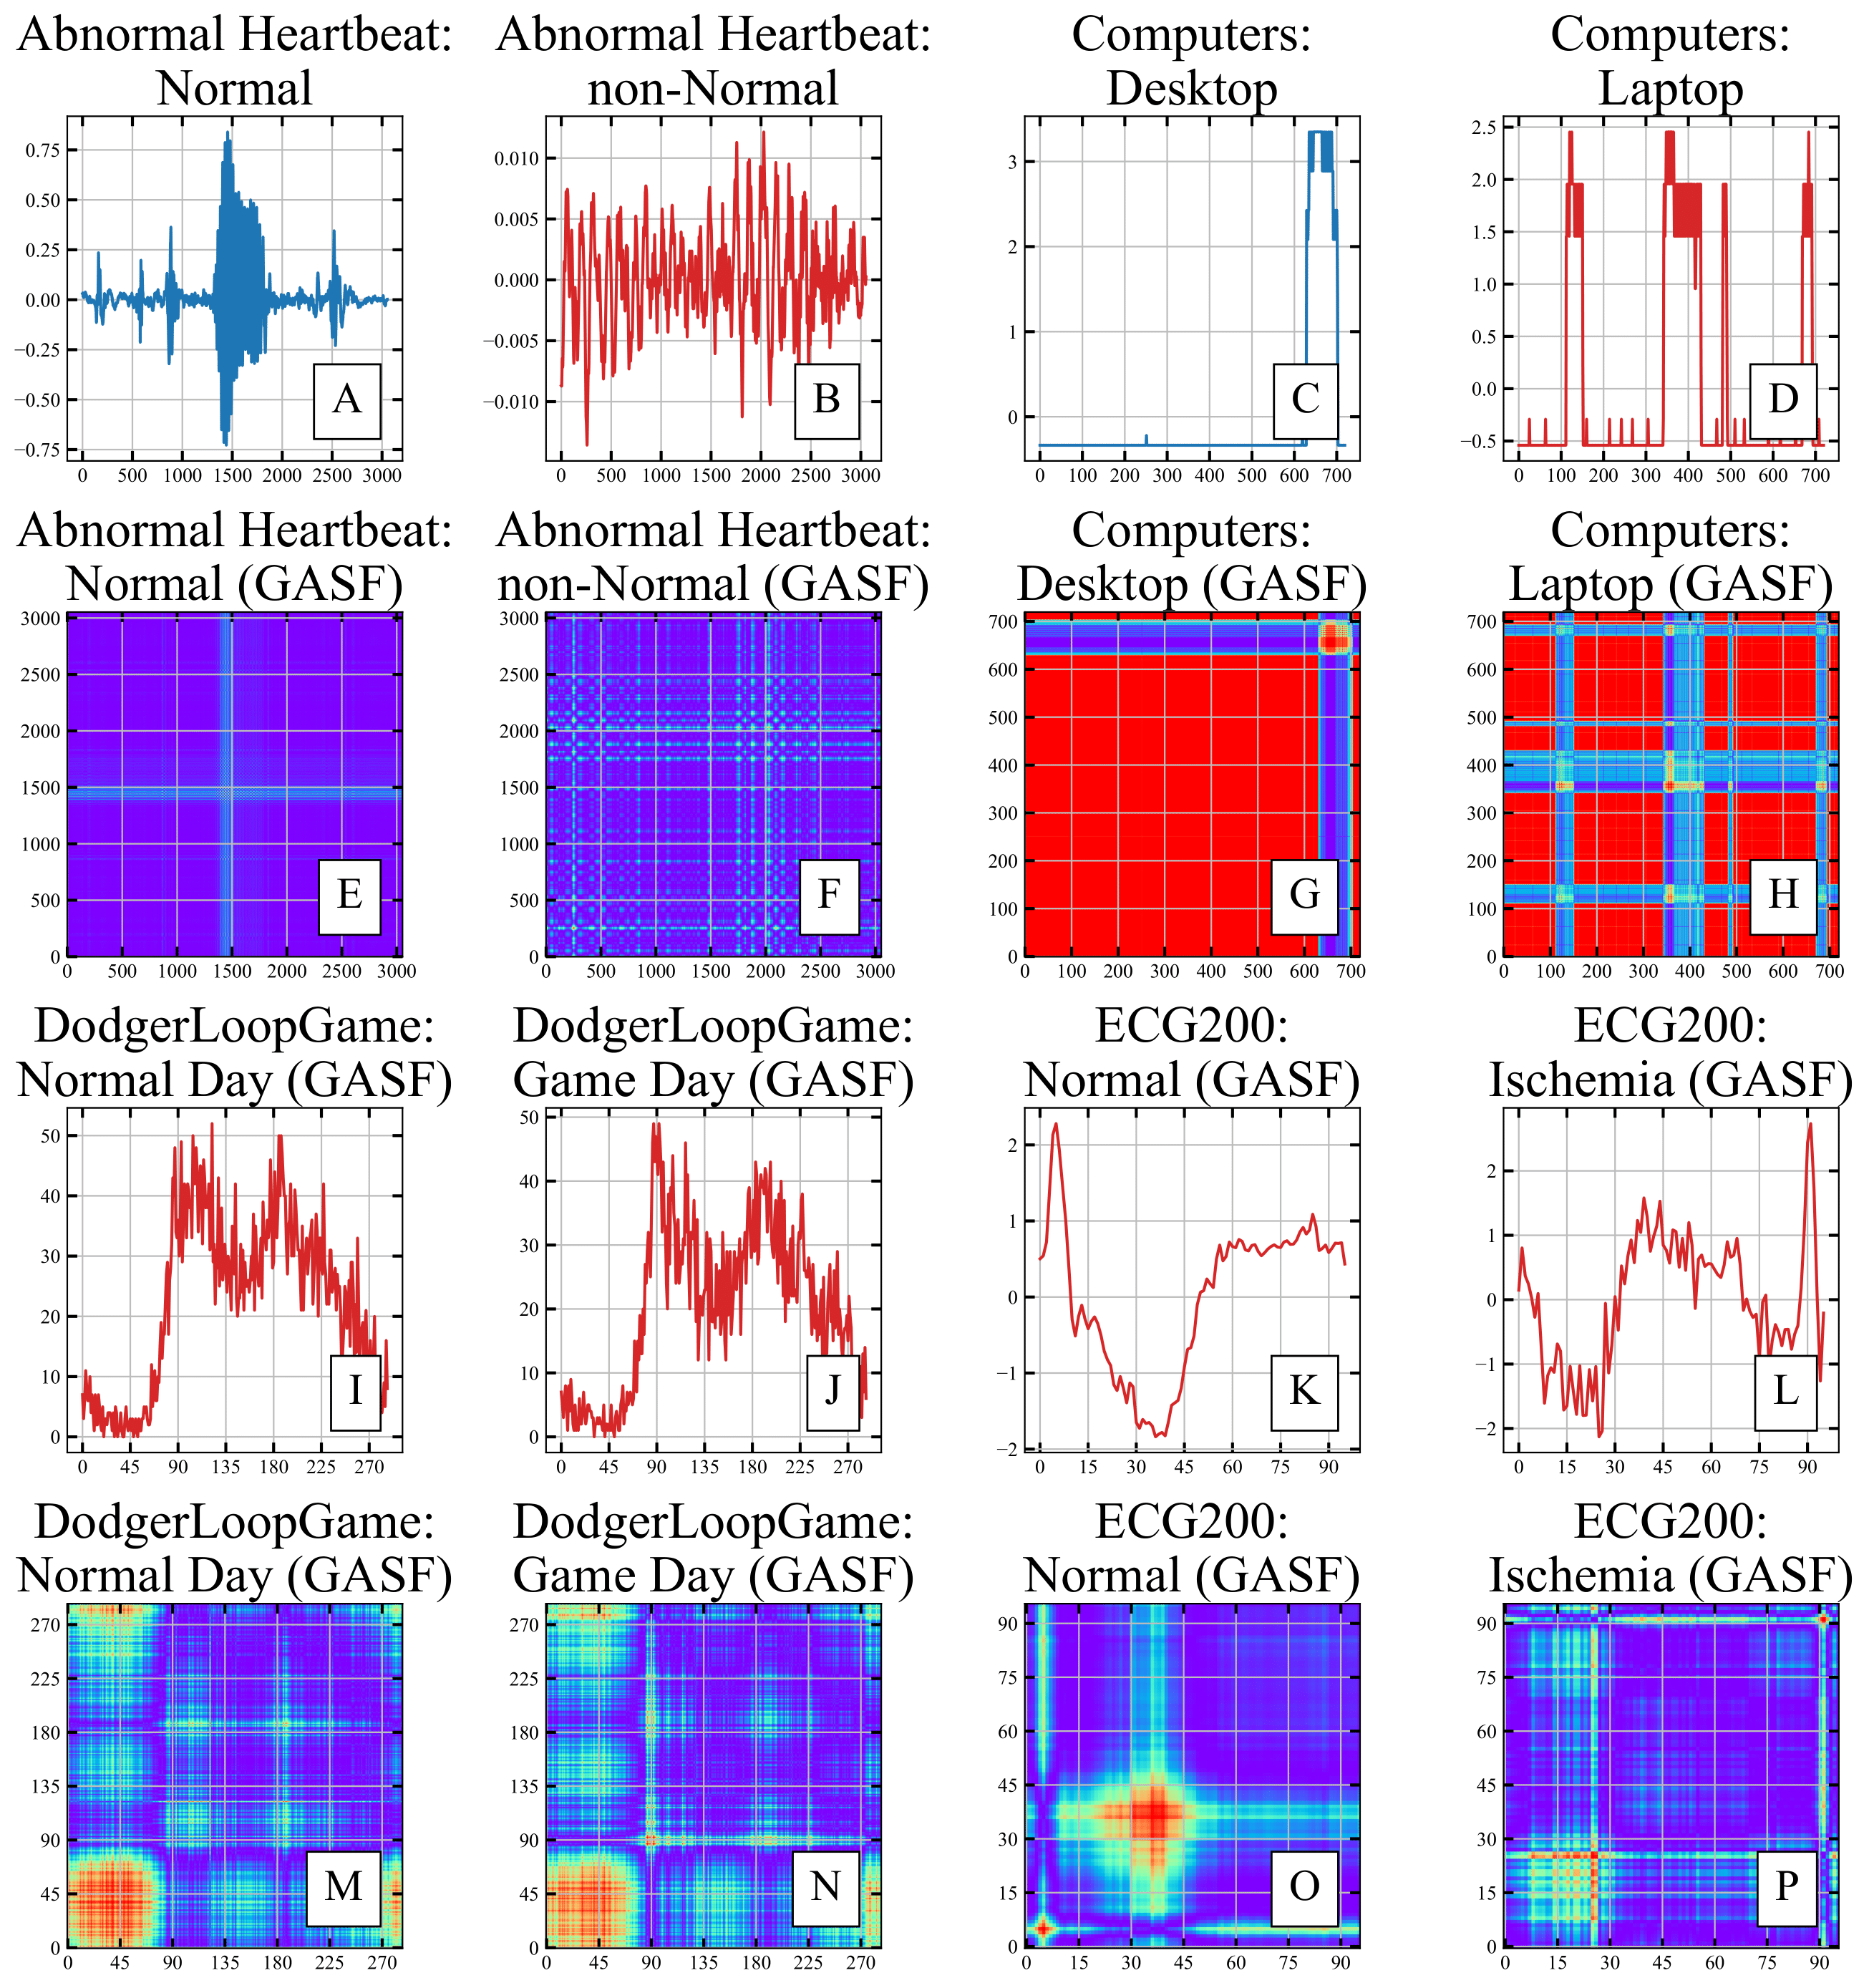

##**Visualization Transform**

In [ ]:
# x and y data for exemplary visualization per step (here: ECG200)
x = range(0, len(np.asarray(data_notarget.loc[indices_label1[0],:])))
y_c0 = np.asarray(data_notarget.loc[indices_label0[0],:])

# General plot parameters
plt.rcParams["figure.figsize"] = (5,5)
fm.fontManager.addfont('/graphics/times.ttf')
fm._rebuild()
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18

# Original time series (raw-connected scatter plot)
ax = plt.subplot()
ax.plot(x, y_c0)
ax.set_xticks(np.arange(min(x), max(x)+1, 15))
plt.savefig('/graphics/Transform_Time.png', bbox_inches='tight', dpi=300)   # save the figure to file 


# Polar encoding
ax = plt.subplot(projection='polar')
ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")
xnorm = (x-np.min(x))/(np.max(x)-np.min(x))*2.*np.pi
ax.plot(xnorm,y_c0)
plt.savefig('/graphics/Transform_Polar.png', bbox_inches='tight', dpi=300)   # save the figure to file 

# GASF
ax = plt.subplot()
ax.imshow(GramianAngularField(method='summation').fit_transform(y_c0.reshape(1, -1))[0], cmap='rainbow', origin='lower', aspect="auto")
ax.set_xticks(np.arange(min(x), max(x)+1, 15))
ax.set_yticks(np.arange(min(x), max(x)+1, 15))
plt.savefig('/graphics/Transform_GASF.png', bbox_inches='tight', dpi=300)   # save the figure to file 

# GADF
ax = plt.subplot()
ax.imshow(GramianAngularField(method='difference').fit_transform(y_c0.reshape(1, -1))[0], cmap='rainbow', origin='lower', aspect="auto")
ax.set_xticks(np.arange(min(x), max(x)+1, 15))
ax.set_yticks(np.arange(min(x), max(x)+1, 15))
plt.savefig('/graphics/Transform_GADF.png', bbox_inches='tight', dpi=300)   # save the figure to file 

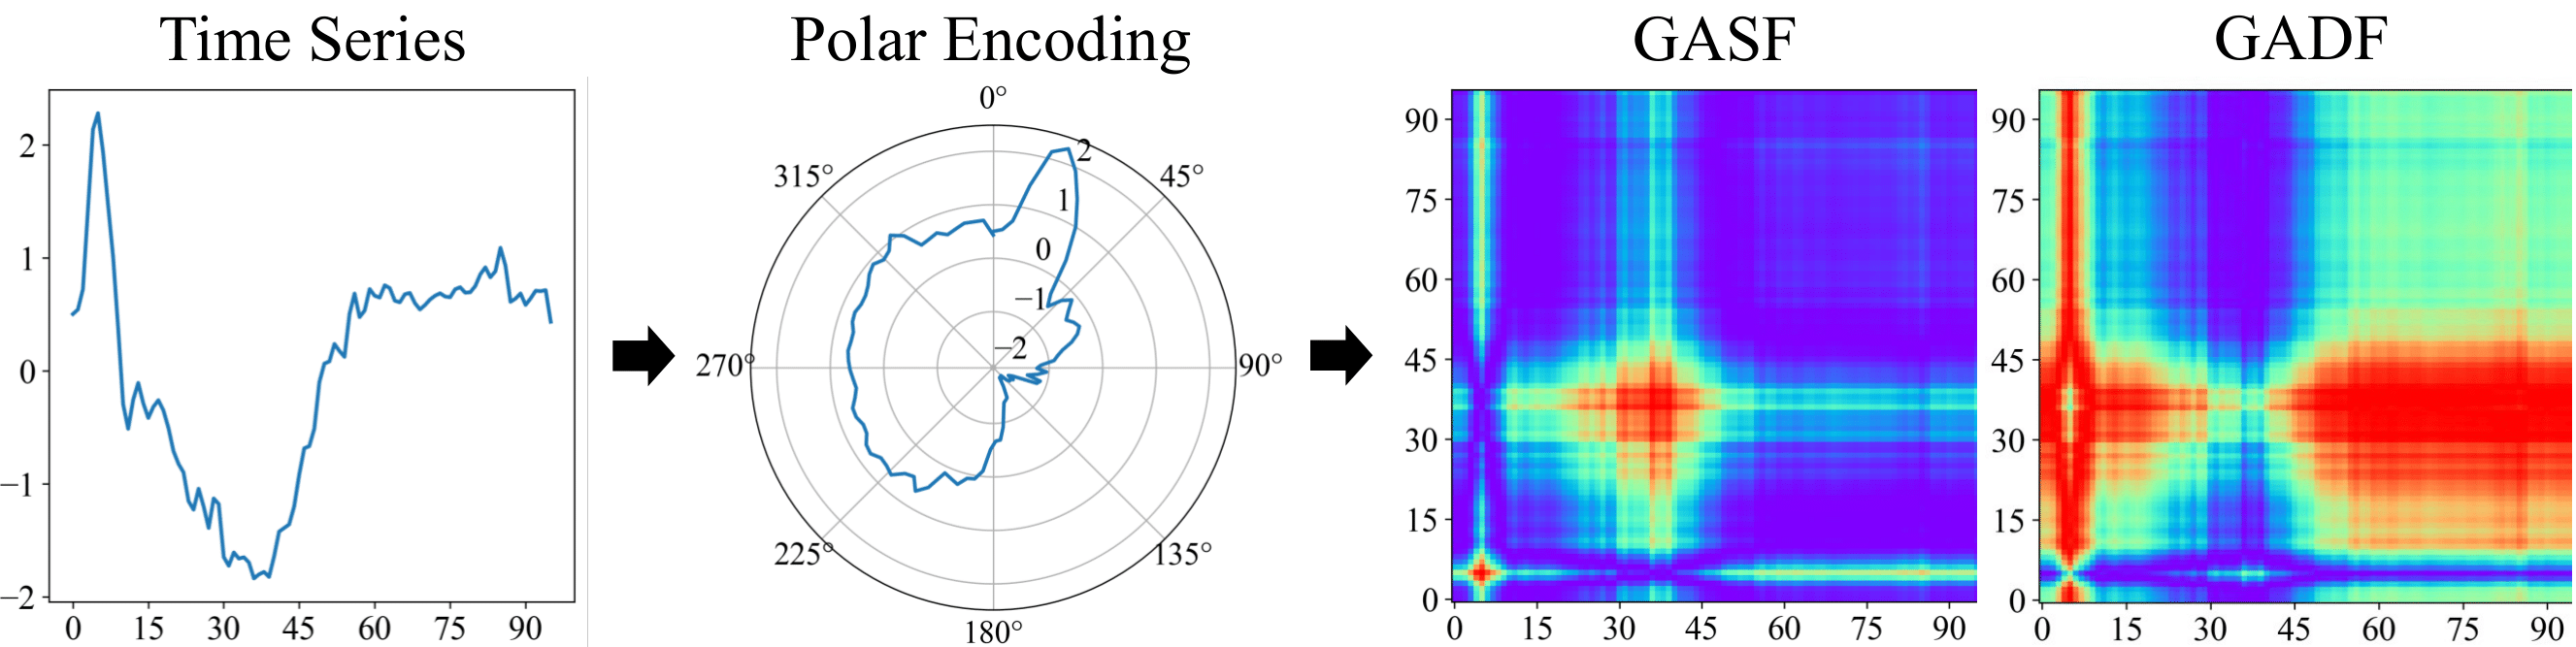

##**Database ECG200 (Workflow)**

In [ ]:
# Create a grid with 36 exemplary ECG200 GASF as representative datase for the visualized workflow

# Set number of columns and rows
columns = 6
rows = 6
o = 1
fig, ax_array = plt.subplots(rows, columns,squeeze=False, figsize=(12,12))

# Iterate through each row and column index
for i,ax_row in enumerate(ax_array):
    for j,axes in enumerate(ax_row):
        axes.set_yticklabels([])
        axes.set_xticklabels([])
        axes.set_xticks([])
        axes.set_yticks([])
        axes.axis('off')
        dat_grid_ecg200 = np.asarray(data_notarget.loc[o,:])
        dat_grid_ecg200 = dat_grid_ecg200.reshape(1, -1)
        axes.imshow(GramianAngularField(method='summation').fit_transform(dat_grid_ecg200)[0], cmap='rainbow', origin='lower', aspect="auto")
        o = o+1
        
fig.tight_layout(pad=0)

plt.savefig('/graphics/workflow_database_ecg200.png', bbox_inches='tight', dpi=300)   # save the figure to file 

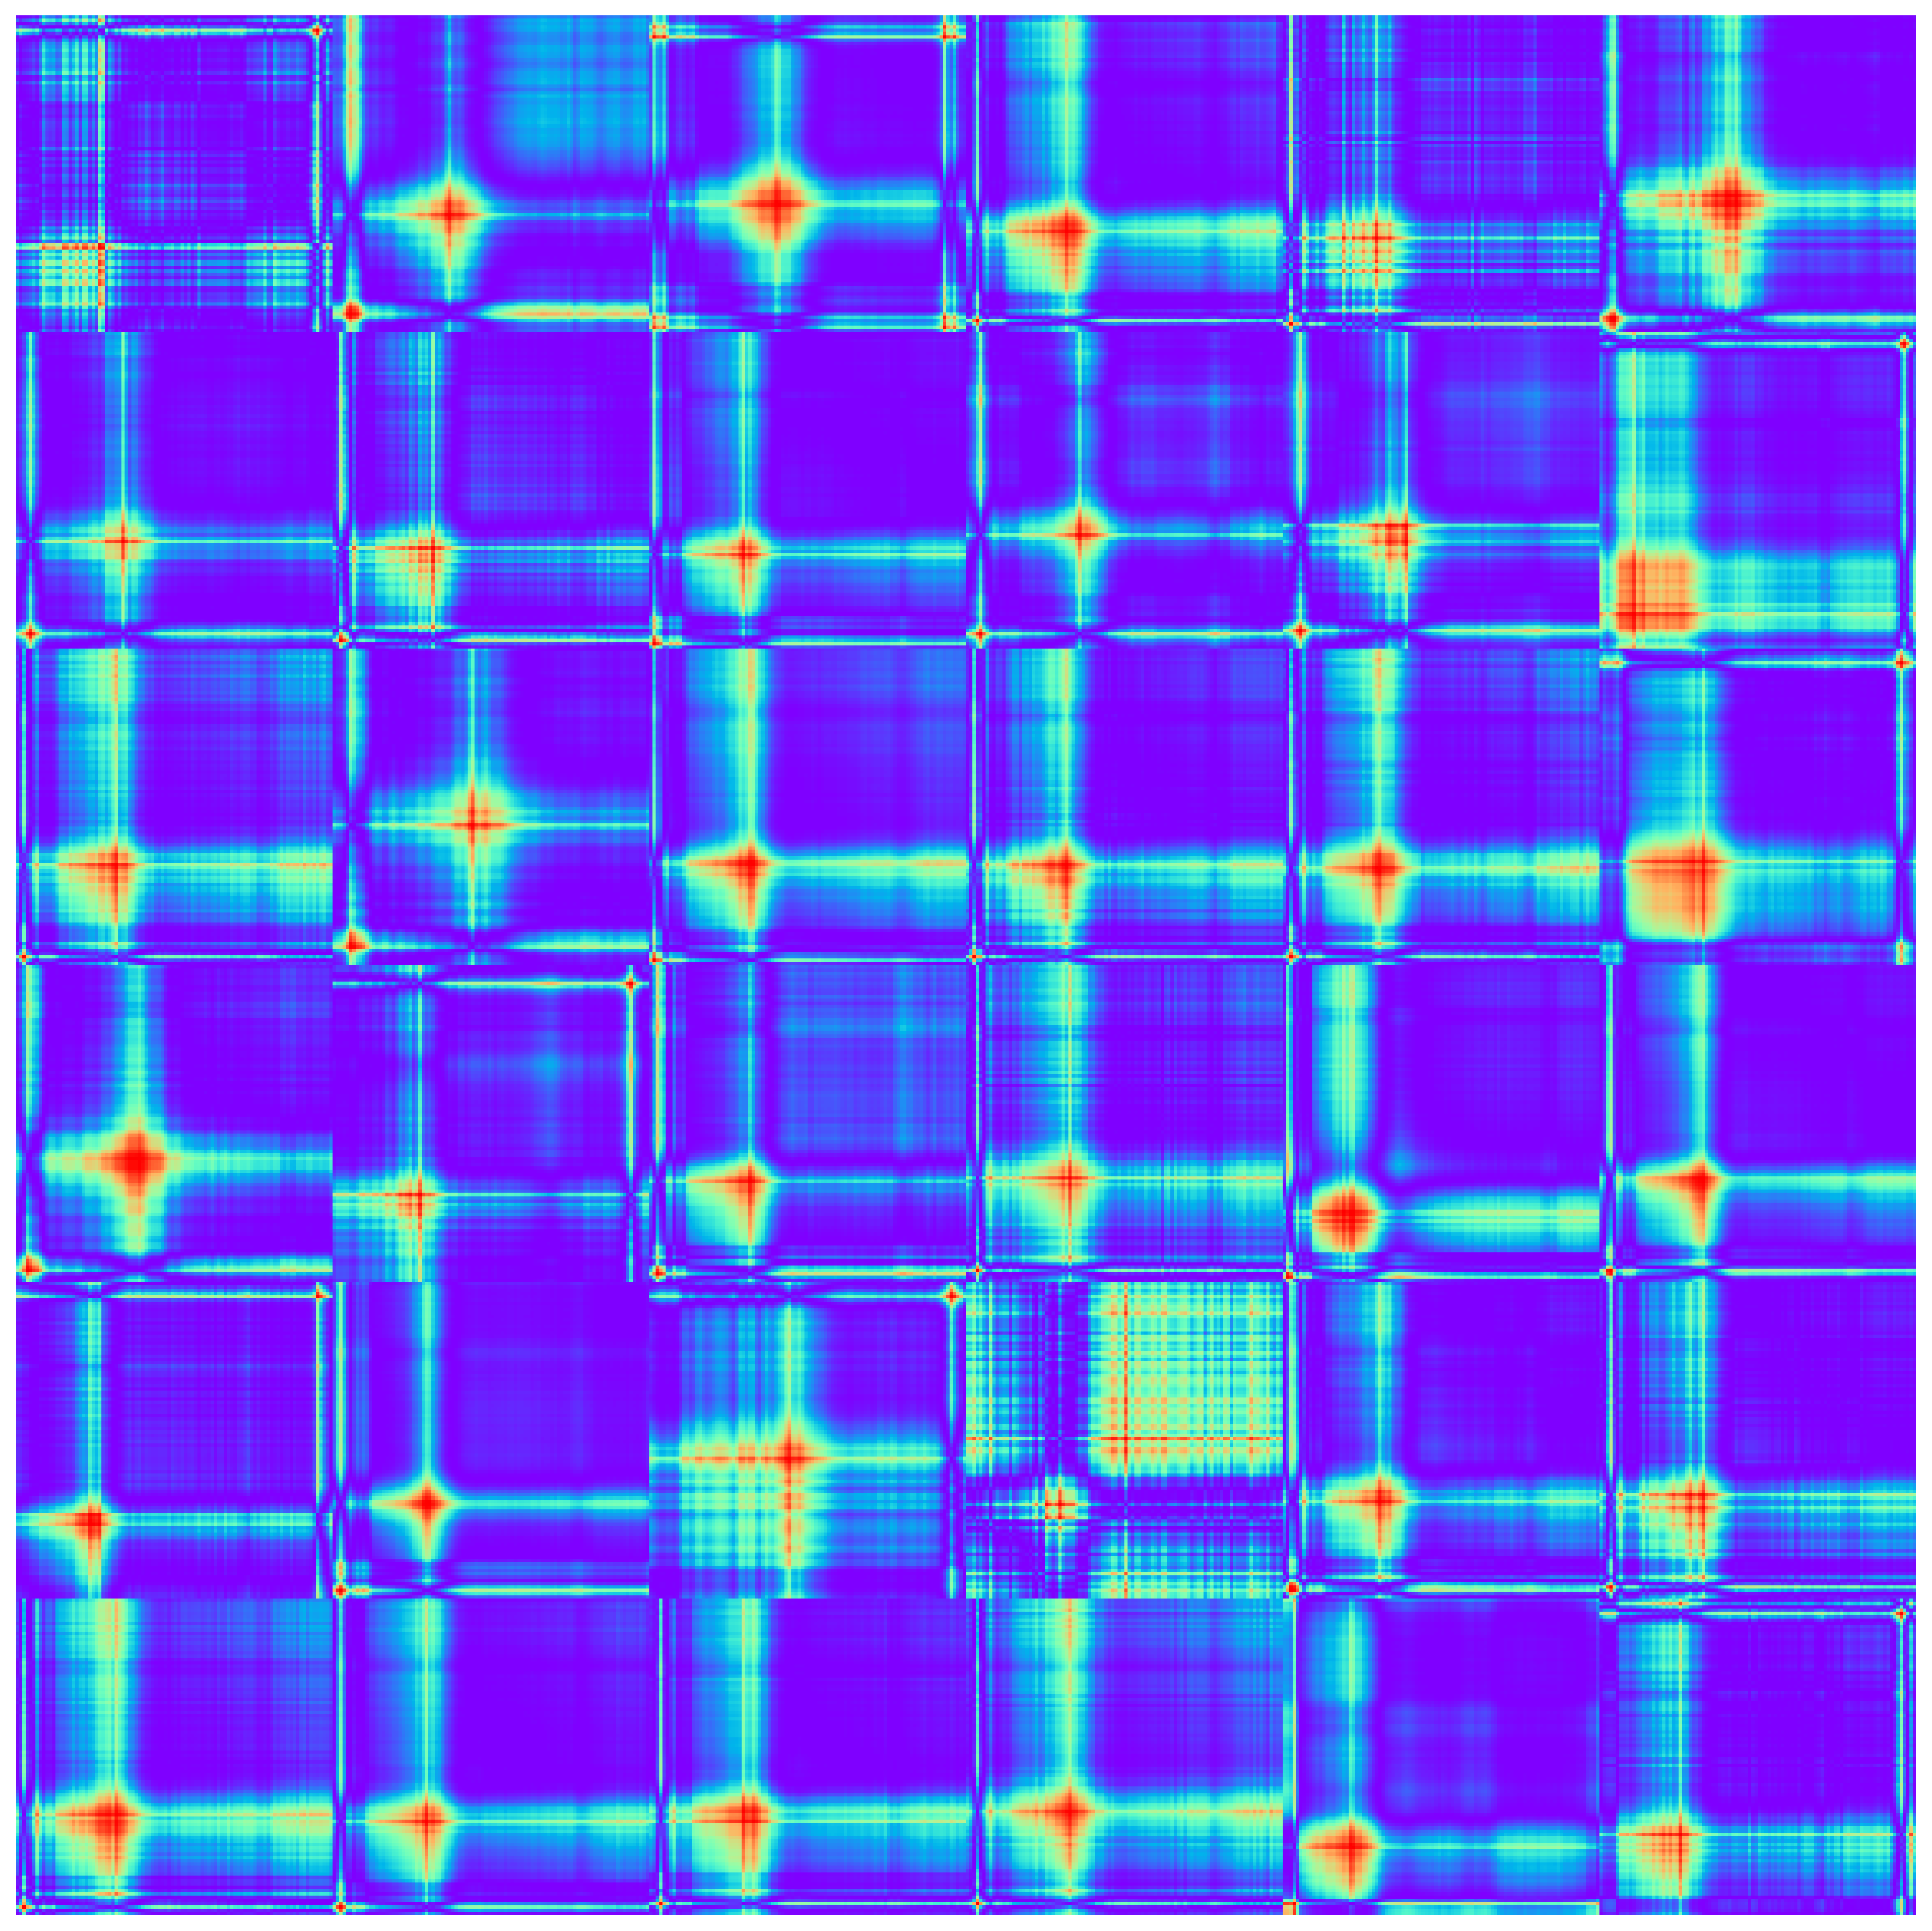

##**Overfit Baseline Model**

In [ ]:
# Load baseline models
model_abnormal = pickle.load(open('/data/' + 'AbnormalHeartbeat' + '/Models_History/Baseline/' + '311104_AbnormalHeartbeat_Base_GADF_1_Fold1.pkl', 'rb'))
model_computers = pickle.load(open('/data/' + 'Computers' + '/Models_History/Baseline/' + '311104_Computers_Base_GADF_1_Fold1.pkl', 'rb'))
model_dodger = pickle.load(open('/data/' + 'DodgerLoopGame' + '/Models_History/Baseline/' + '311104_DodgerLoopGame_Base_GADF_1_Fold1.pkl', 'rb'))
model_ecg200 = pickle.load(open('/data/' + 'ECG200' + '/Models_History/Baseline/' + '311104_ECG200_Base_GADF_1_Fold1.pkl', 'rb'))

# General plot parameters
plt.rcParams["figure.figsize"] = (10,5)
fm.fontManager.addfont('/graphics/times.ttf')
fm._rebuild()
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['legend.fontsize'] = 18

# Plot loss function (training and validation) for each dataset/model

# Abnormal Heartbeat
ax = plt.subplot()
ax.plot(model_abnormal['loss'], color='dodgerblue')
ax.plot(model_abnormal['val_loss'], color='dodgerblue', linestyle='dashed')

# Computers
ax.plot(model_computers['loss'], color='mediumvioletred')
ax.plot(model_computers['val_loss'], color='mediumvioletred', linestyle='dashed')

# DodgerLoopGame
ax.plot(model_dodger['loss'], color='orange')
ax.plot(model_dodger['val_loss'], color='orange', linestyle='dashed')

# ECG200
ax.plot(model_ecg200['loss'], color='seagreen')
ax.plot(model_ecg200['val_loss'], color='seagreen', linestyle='dashed')

# Set labels
ax.set_ylabel('Model Loss')
ax.set_xlabel('Epoch')

# Create first legend (loss functions)
first_legend = plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
first_legend.legendHandles[0].set_color('black')
first_legend.legendHandles[1].set_color('black')
# Add the legend manually to the current Axes.
ax = plt.subplot().add_artist(first_legend)

custom_lines = [Line2D([0], [0], color='dodgerblue', lw=2),
                Line2D([0], [0], color='mediumvioletred', lw=2),
                Line2D([0], [0], color='orange', lw=2),
                Line2D([0], [0], color='seagreen', lw=2)]

# Draw vertical line (begin of overfitting)
plt.axvline(x=20, color='firebrick')
plt.text(20.3,2.15,'Overfit', rotation=90,color='firebrick', fontsize=18)

# Create second legend (datasets)
plt.legend(custom_lines, ['AbnormalHeartbeat', 'Computers', 'DodgerLoopGame', 'ECG200'])


plt.savefig('/graphics/overfit_baseline.pdf', bbox_inches='tight', dpi=300)   # save the figure to file 

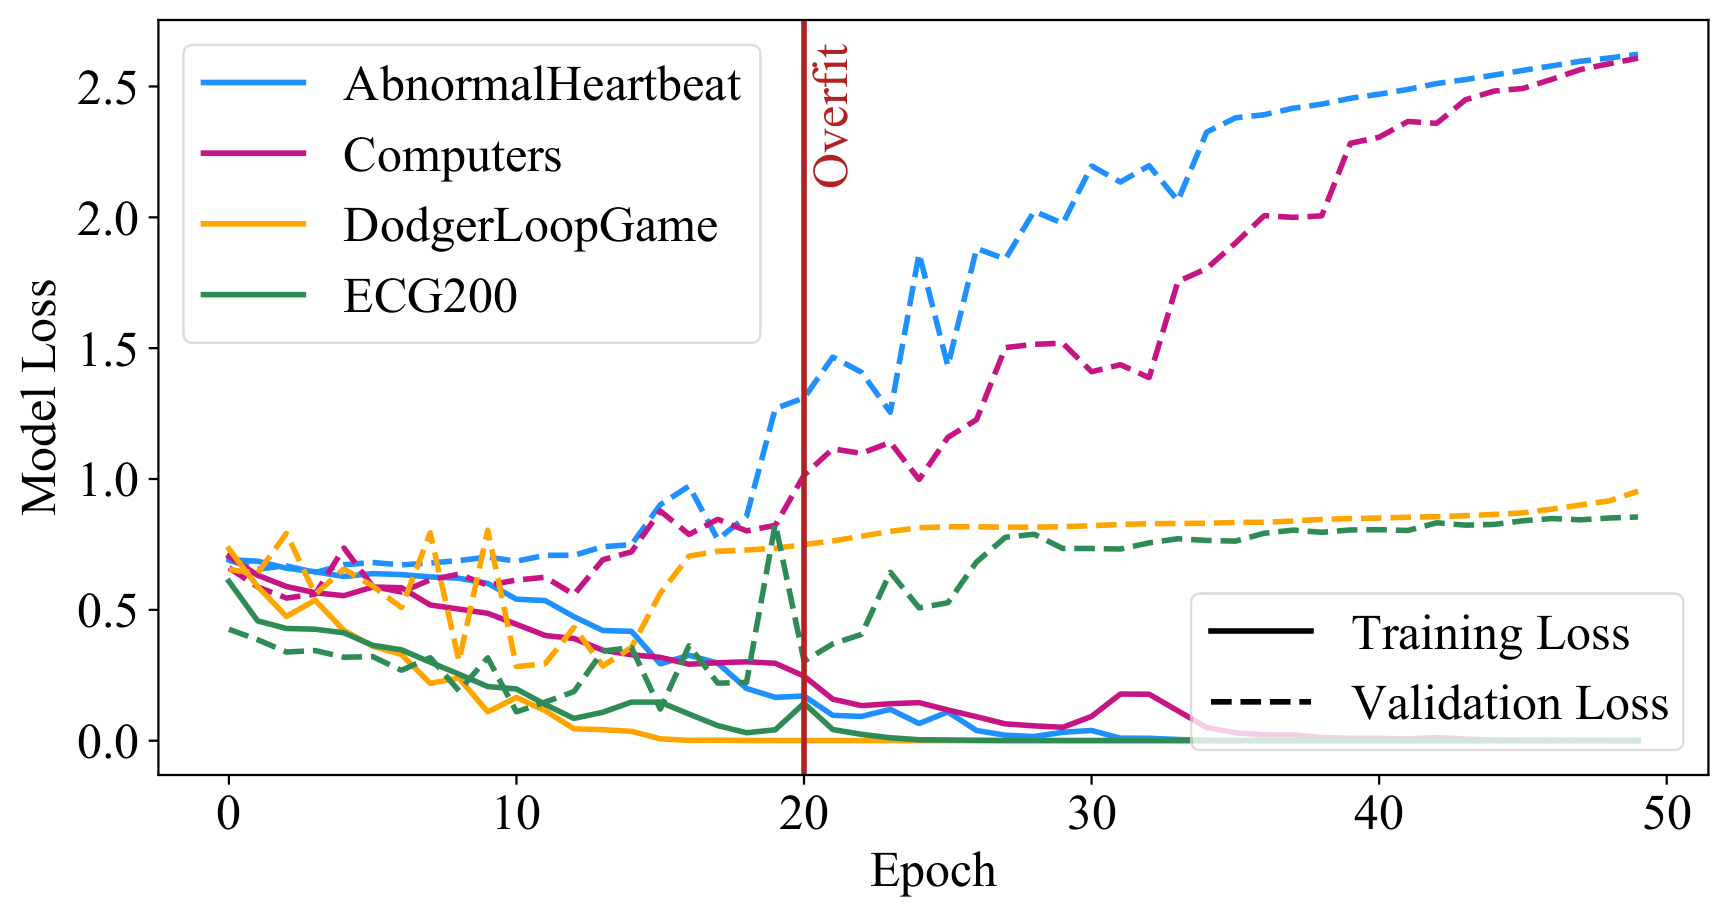

##**VGG16 Feature Representation**

**Define Same Test Split As Used In Training And Evaluation**

In [53]:
# General settings (based on GASF visualization and VGG16 model)
ds = 3
method = 'GASF'
mthd_path = '/GASF_Complete/'
tp = 'TransferLearning'
feature = 'VGG16Tune'

# Identify all models that match settings criteria
models = glob.glob('/data/' + datasets[ds] + '/Models_History/' + tp + '/*.h5')
models_selected = [k for k in [k for k in [k for k in models if 'Tune' in k] if method in k] if feature in k]

# Load the model for representation
model = load_model(models_selected[0])

# Load the data
# Automatically reads in all images and gets labels from direcetory names
data_generator = ImageDataGenerator()

# Define paths for data subset
sDataPath = '/data/' + datasets[ds] + mthd_path

# Image size
img_W = 224
img_H = 224

# Define batch size for directory flow according to dataset
if ds == 0:
  bsz = 606
elif ds == 1:
  bsz = 500
elif ds == 2:
  bsz = 144
elif ds == 3:
  bsz = 200

# Read-in images and receive Labels
data_gen = data_generator.flow_from_directory(sDataPath,color_mode='rgb', 
                                                     class_mode='binary', target_size=(img_H, img_W), batch_size=bsz, shuffle=False)
for x_data_raw, y_data in data_gen:
    break

# Rescale data to [-1,1]
x_data = (x_data_raw * (1/127.5)) - 1

# Create hold-out-split with same class distribution as dataset (20%)
inputs, x_test, targets, y_test = train_test_split(x_data, y_data, stratify=y_data, test_size=0.2, random_state=42)

Found 200 images belonging to 2 classes.


In [ ]:
idx = 39
img_tensor = np.uint8((x_test[idx] + 1) * 127.5).reshape(1,224,224,3)
layer_outputs = [layer.output for layer in model.layers][1:]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

layer_names = []
for layer in model.layers[1:22]:
    layer_names.append(layer.name) # Appends the name for each model layer
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Feature maps
    n_features = layer_activation.shape[-1] # Number of features
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    dsp_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            ch_img = layer_activation[0,:, :, col * images_per_row + row]
            ch_img -= ch_img.mean()
            ch_img /= ch_img.std()
            ch_img = ch_img*64
            ch_img = ch_img+128
            ch_img = np.clip(ch_img, 0, 255).astype('uint8')
            dsp_grid[col * size : (col + 1) * size, # Displaying grid
                         row * size : (row + 1) * size] = ch_img
    scale = 1. / size
    plt.figure(figsize=(scale * dsp_grid.shape[1],
                        scale * dsp_grid.shape[0]))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(dsp_grid, aspect='auto', cmap='viridis')
    img_path = '/graphics/Feature Maps VGG16/' + layer_name + '.png'
    plt.savefig(img_path, bbox_inches='tight', pad_inches=0, dpi=300)   # save the figure to file 

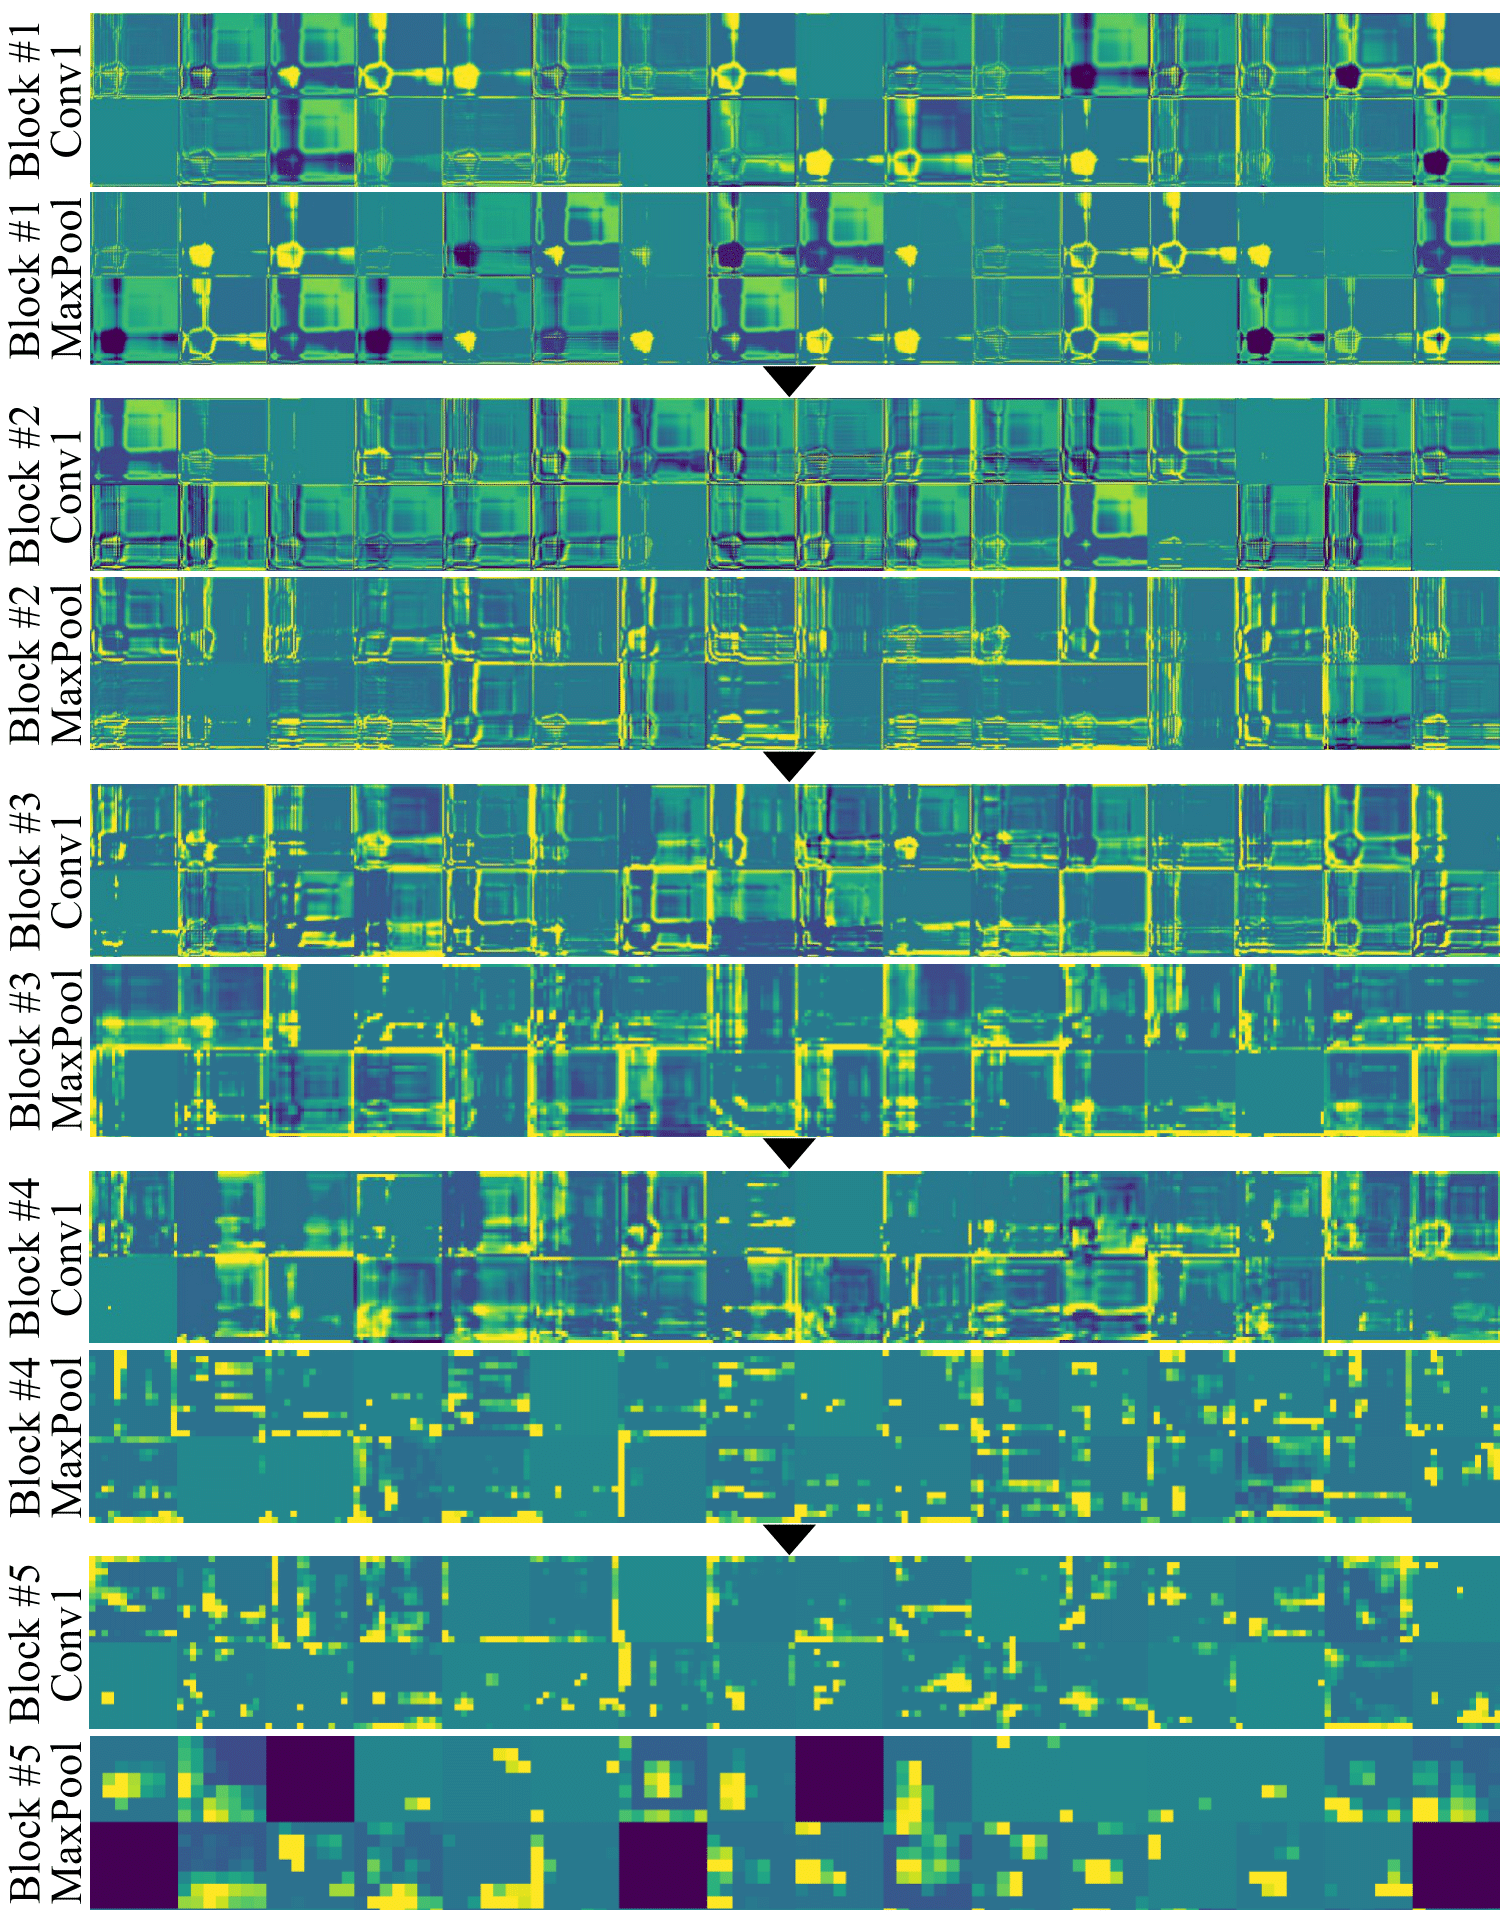

##**VGG16 Heatmap Examples**

**Define Function To Be Called For Creating The Heatmap**

In [49]:
def getHeatMap(inp_img, class_idx, last_layer):
    #Get the output tensor from the model and get the last convlayer from model
    with tf.device('/gpu:0'):
        miss = model.output[class_idx]
        last_conv_layer = model.get_layer(last_layer)

        #Calculate gradient of output with respect to output of last convlayer
        grads = K.gradients(miss, last_conv_layer.output)[0]

        #Pool the gradients over all channels 
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

        #Function returns the values of the pooled grads and the output value of the layers
        iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

        # Run function to the values for x
        pooled_grads_value, conv_layer_output_value = iterate([inp_img])
    
    for i in range(len(pooled_grads_value)):
        conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
    
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    return heatmap

In [ ]:
idx = 26 # Index of image to be plotted

# General plot parameters
plt.rcParams["figure.figsize"] = (5,5)
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
fontColor = (0,0,0)
lineType = 2

# GASF representation of selected index
ax = plt.subplot()
ax.axis('off')
ax.imshow(np.uint8((x_test[idx] + 1) * 127.5))
plt.savefig('/graphics/Heatmaps Examples/Dodger_GASF.png', bbox_inches='tight', pad_inches=0, dpi=300)   # save the figure to file 


# Heatmap (Grad-CAM) representation of selected index
last_layer = 'block5_conv3'

# Convert the labels into integers
yt = np.uint8(y_test)

# Expand the dimensionality so it fits to the Keras scheme
x = np.expand_dims(x_test[idx],axis=0)

# Get the heatmaps for the selected image 
heatmap_val_org = getHeatMap(x, 0, last_layer) # class_index to 0 due to sigmoid activation
heatmap_val = heatmap_val_org.copy()

# Color the valence heatmap and combine it with the image 
heatmap_val = np.uint8(heatmap_val * 255.)
heatmap_val = cv2.resize(heatmap_val, (x.shape[2], x.shape[1]))
heatmap_val = cv2.applyColorMap(heatmap_val, cv2.COLORMAP_JET)

plt.imshow(np.uint(heatmap_val))
plt.axis('off')
plt.savefig('/graphics/Heatmaps Examples/Dodger_GASF_HM.png', bbox_inches='tight', pad_inches=0, dpi=300)   # save the figure to file 

In [ ]:
# Load GASF and heatmap image for each dataset and display it in a 2x4 subplot-grid
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(13.25,7))

# General plot parameters
fm.fontManager.addfont('/graphics/times.ttf')
fm._rebuild()
plt.rcParams['axes.titlesize'] = 26
plt.rcParams['font.family'] = 'Times New Roman'

# Abnormal Heartbeat
Abnormal_GASF = plt.imread('/graphics/Heatmaps Examples/Abnormal_GASF.png')
ax1.imshow(Abnormal_GASF)
ax1.axis('off')
Abnormal_GASF_HM = plt.imread('/graphics/Heatmaps Examples/Abnormal_GASF_HM.png')
ax5.imshow(Abnormal_GASF_HM)
ax5.axis('off')

# Computers
Computers_GASF = plt.imread('/graphics/Heatmaps Examples/Computers_GASF.png')
ax2.imshow(Computers_GASF)
ax2.axis('off')
Computers_GASF_HM = plt.imread('/graphics/Heatmaps Examples/Computers_GASF_HM.png')
ax6.imshow(Computers_GASF_HM)
ax6.axis('off')

# Dodger
Dodger_GASF = plt.imread('/graphics/Heatmaps Examples/Dodger_GASF.png')
ax3.imshow(Dodger_GASF)
ax3.axis('off')
Dodger_GASF_HM = plt.imread('/graphics/Heatmaps Examples/Dodger_GASF_HM.png')
ax7.imshow(Dodger_GASF_HM)
ax7.axis('off')

# ECG200
ECG200_GASF = plt.imread('/graphics/Heatmaps Examples/ECG200_GASF.png')
ax4.imshow(ECG200_GASF)
ax4.axis('off')
ECG200_GASF_HM = plt.imread('/graphics/Heatmaps Examples/ECG200_GASF_HM.png')
ax8.imshow(ECG200_GASF_HM)
ax8.axis('off')

# Set titles
ax1.title.set_text('Abnormal Heartbeat',)
ax2.title.set_text('Computers')
ax3.title.set_text('DodgerLoopGame')
ax4.title.set_text('ECG200')

fig.tight_layout(pad=-1)

plt.savefig('/graphics/heatmap_example.pdf', bbox_inches='tight', pad_inches=0, dpi=300)   # save the figure to file 

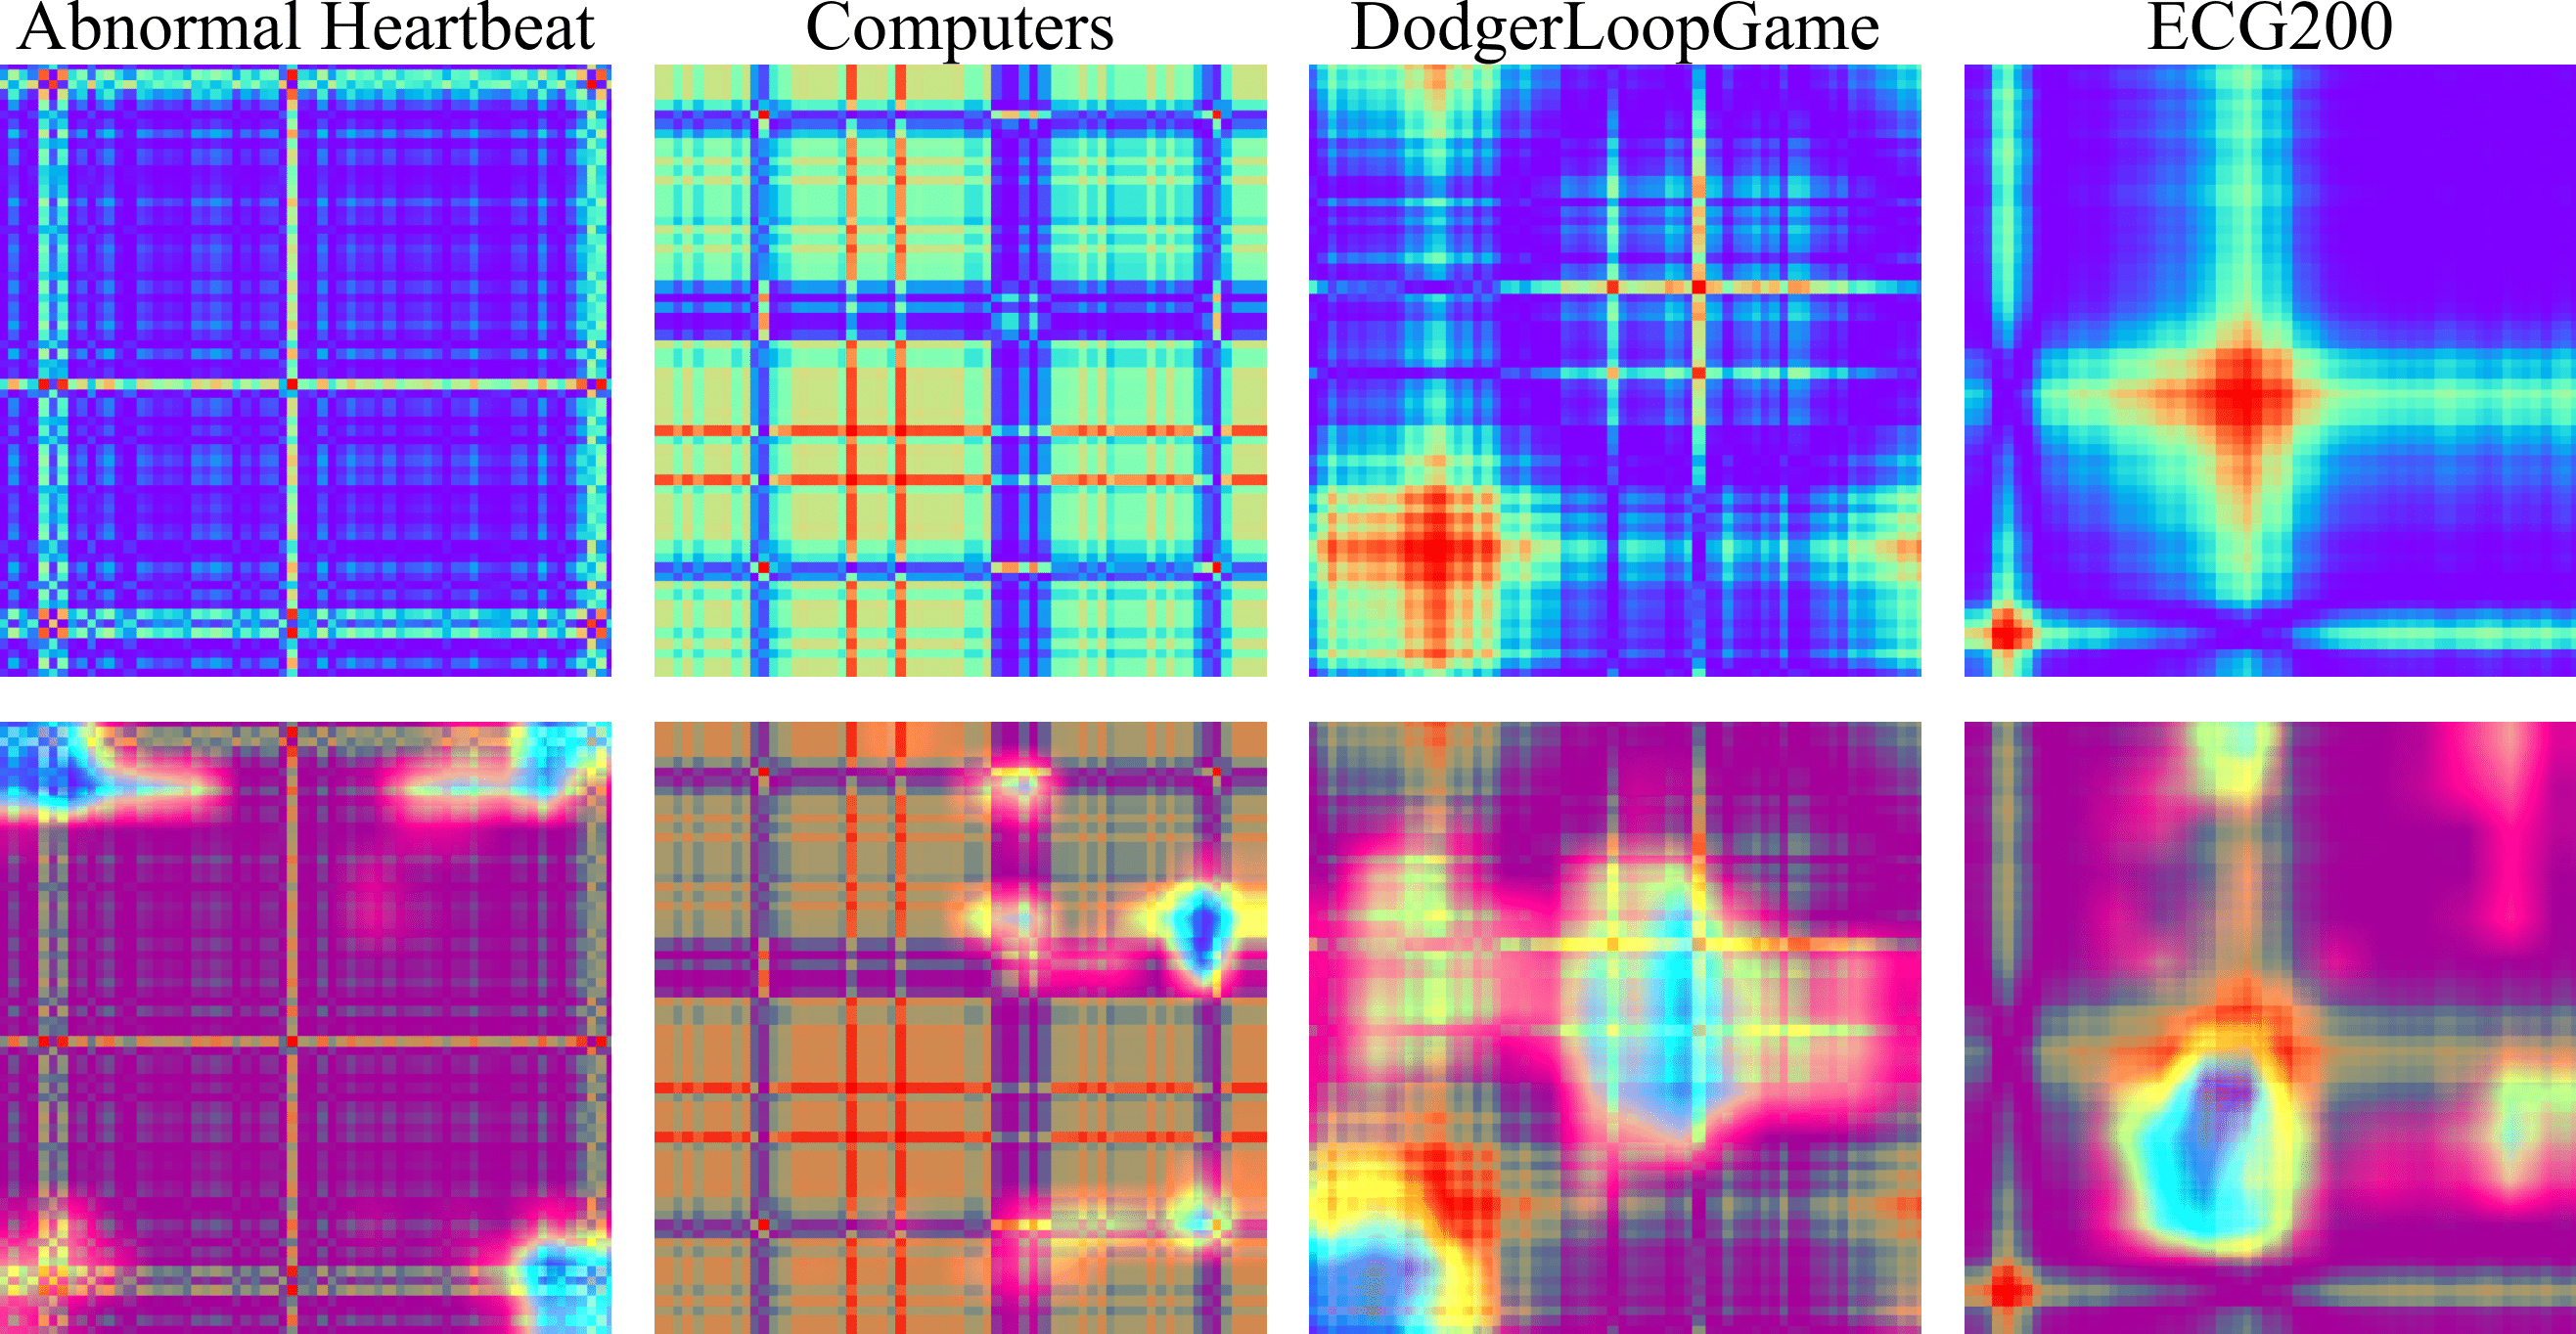